# Fixed Income Lecture

Welcome to this in-depth session on **Fixed Income Analytics** — where we move from bond fundamentals to professional-grade valuation techniques using both **Python** and **QuantLib**.

Bonds may appear simple — a stream of future payments — but their valuation and risk management require rigorous understanding of time value, interest rate dynamics, and market conventions. This lecture blends **theory**, **hands-on code**, and **institutional tools** to provide a comprehensive foundation.

### What You'll Learn Today:

- **Bond Mechanics** — cash flows, coupons, and the relationship between price and yield  
- **Yield to Maturity (YTM)** — interpreting a bond’s internal rate of return  
- **Duration and Convexity** — measuring first- and second-order interest rate risk  
- **Price Sensitivity Analysis** — using Taylor expansions and actual repricing  
- **Yield Curve Construction** — interpolating spot and forward rates from market data  
- **Clean vs. Dirty Price** — handling accrued interest in pricing and settlement  
- **Amortization and Accretion** — understanding the pull-to-par effect  
- **QuantLib Integration** — validating manual calculations with industry tools  
- **Visual Analysis** — interpreting bond and curve behavior through plots and simulations  

This session is designed for students and practitioners alike. Whether you're preparing for an exam or developing fixed income models, you’ll gain practical intuition and a reusable code base.

Let’s begin — with theory, data, and models that reflect real-world fixed income markets.

### Requirements (Python Libraries, Plot Settings, Colors...)

In [1]:
# Requirements
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install statsmodels
!pip install plotly
!pip install QuantLib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import QuantLib as ql

from scipy.interpolate import interp1d, PchipInterpolator
import statsmodels.api as sm

# Plot settings
sns.set_theme(style="whitegrid", rc={"figure.figsize": (12, 6)})
old_money_palette = [
    "#3B4C66",  # Navy
    "#2E4F36",  # Forest Green
    "#C1A45F",  # Gold Ochre
    "#E6D4B8",  # Muted Champagne
    "#5E5C58",  # Oxide Grey
    "#4C2C2B",  # Deep Burgundy
    "#3D5A40",  # Hunter Green
    "#F4EFE6",  # Ivory Cream
    "#6A5841",  # Dark Bronze
]

sns.set_palette(old_money_palette)

# Constants
PATH_TO_CSV_FILES = "C:/Users/User/OneDrive/Documents/QPMwP/Data/" # <Adjust this path as needed>



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# How bonds work
## 1. Cash Flows of a Plain Vanilla Bond

A plain vanilla bond pays fixed coupons periodically and repays face value at maturity.

**Example:**  
- Face Value = 1'000  
- Coupon Rate = 5%  
- Annual Payments  
- Maturity = 10 years

**Cash Flows (in \$):**

| Year         | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10     |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|--------|
| Cash Flow    | 50  | 50  | 50  | 50  | 50  | 50  | 50  | 50  | 50  | 1'050  |



In [2]:

# Bond parameters
face_value = 1000
coupon_rate = 0.05
maturity = 10
frequency = 1

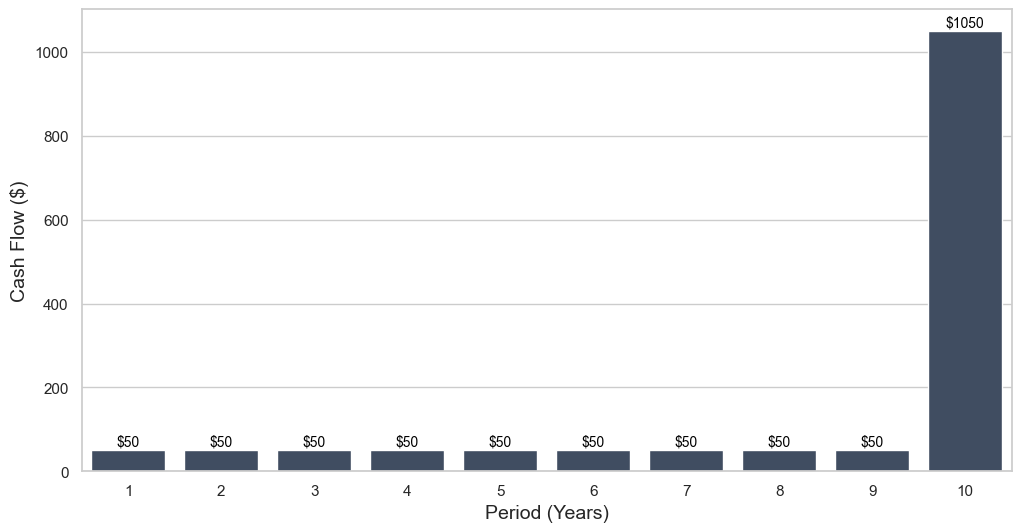

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette(old_money_palette)

# Bond parameters
face_value = 1000
coupon_rate = 0.05
maturity = 10
frequency = 1

# Function to generate bond cash flows
def bond_cash_flows(face_value, coupon_rate, maturity, frequency):
    periods = int(maturity * frequency)
    coupon = face_value * coupon_rate / frequency
    cash_flows = [coupon] * periods
    cash_flows[-1] += face_value  # Add face value to the last cash flow
    return pd.DataFrame({
        'Period': range(1, periods + 1),
        'Cash Flow': cash_flows
    })

# Function to calculate the present value of a bond
def bond_price(cash_flows, discount_rate):
    periods = cash_flows['Period']
    cash_flow_values = cash_flows['Cash Flow']
    return np.sum(cash_flow_values / (1 + discount_rate) ** periods)

# Generate bond cash flows
cash_flows = bond_cash_flows(face_value, coupon_rate, maturity, frequency)

# Plot the cash flows
plt.figure(figsize=(12, 6))
sns.barplot(x=cash_flows['Period'], y=cash_flows['Cash Flow'])
plt.xlabel("Period (Years)", fontsize=14)
plt.ylabel("Cash Flow ($)", fontsize=14)
# Annotate bars
for index, row in cash_flows.iterrows():
    plt.text(index, row['Cash Flow'] + 10, f"${row['Cash Flow']:.0f}",
             ha='center', color="black", fontsize=10)

plt.show()

## 2. Time Value of Money

The **time value of money** is a foundational concept in fixed income analysis. It reflects the idea that a dollar received today is worth more than a dollar received in the future, due to its potential earning capacity. This principle is central to the valuation of bonds and other financial instruments.

To determine the value of a bond or any stream of future cash flows, we must discount each future payment to its present value using an appropriate **discount rate**, which reflects the opportunity cost of capital and the risk associated with the cash flows.

### Present Value Formula

The present value of a single future cash flow is calculated as:

$$
PV = \frac{CF}{(1 + r)^t}
$$

Where:
- $PV$ = present value of the cash flow  
- $CF$ = amount of the cash flow at time $t$  
- $r$ = discount rate (per period, expressed in decimal form)  
- $t$ = number of periods until payment

This formula adjusts the future payment to reflect the amount that would be equivalent in today's terms, assuming reinvestment at rate $r$.

### Application to Bond Cash Flows

Consider the bond from Section 1:

- Face Value = 1,000  
- Coupon Rate = 5%  
- Annual coupon = \$50  
- Maturity = 10 years  
- Discount Rate = 4%

Each coupon and the principal repayment are discounted to the present using the formula above. The sum of these present values gives the **market price** of the bond. For example, the present value of the first coupon is:

$$
PV = \frac{50}{(1 + 0.04)^1} = 48.08
$$

And the final payment of \$1,050 at year 10 is:

$$
PV = \frac{1{,}050}{(1 + 0.04)^{10}} = \frac{1{,}050}{1.48024} \approx 709.26
$$

In [4]:
def bond_cash_flows(face_value, coupon_rate, maturity, frequency, yld):
    periods = int(maturity * frequency)
    coupon = face_value * coupon_rate / frequency
    cash_flows = [coupon] * periods
    cash_flows[-1] += face_value  # Add face value to the last cash flow
    return pd.DataFrame({
        'Period': range(1, periods + 1),
        'Cash Flow': cash_flows,
        'Discounted Value': [cf / (1 + yld) ** p for p, cf in zip(range(1, periods + 1), cash_flows)]})

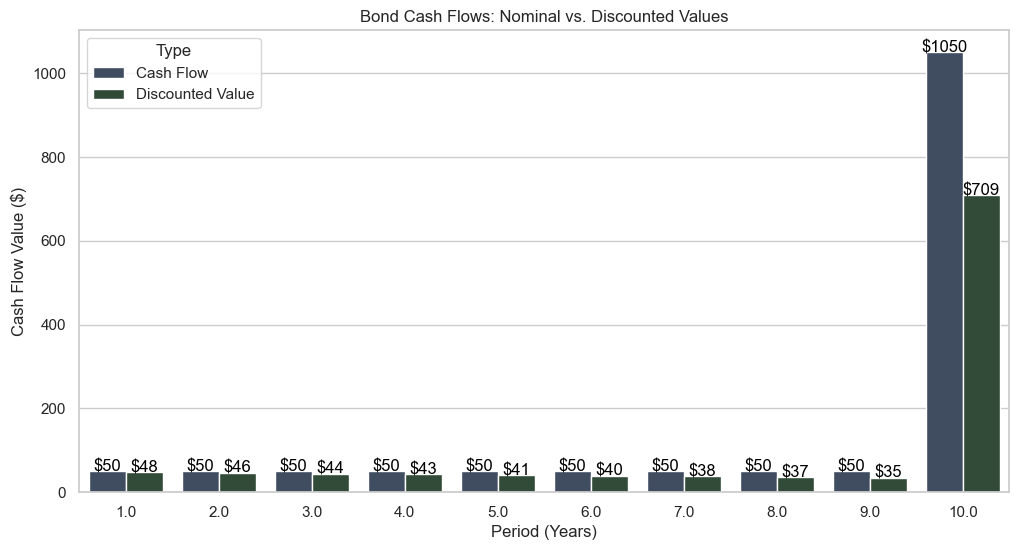

In [5]:
cash_flows_pv = bond_cash_flows(face_value, coupon_rate, maturity, frequency, 0.04)

long_cash_flows = pd.melt(
    cash_flows_pv,
    id_vars=['Period'], value_vars=['Cash Flow', 'Discounted Value'],
    var_name='Type', value_name='Value')

long_cash_flows["Period"] = long_cash_flows["Period"].astype(float)
ax = sns.barplot(data=long_cash_flows, x="Period", y="Value", hue="Type")
for bar, row in zip(ax.patches, long_cash_flows.itertuples()):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1,
    f"${row.Value:.0f}", ha='center', fontsize=12, color="black")
plt.xlabel("Period (Years)")
plt.ylabel("Cash Flow Value ($)")
plt.title("Bond Cash Flows: Nominal vs. Discounted Values")
plt.show()

## 3. Par, Discount, and Premium Bonds

A core principle in bond valuation is the relationship between a bond’s **coupon rate**, its **yield to maturity (YTM)** — or discount rate — and its **price**. This relationship determines whether the bond trades at **par**, **a premium**, or **a discount**.

### Par Bond
A bond trades **at par** when its **price equals its face value** (typically \$1,000). This occurs when the **coupon rate equals the YTM** — meaning the bond’s promised interest payments match the return demanded by the market.
> **Coupon Rate = Discount Rate**
> **Price = Face Value**

**Example**:  
At a **discount rate of 5%**, the bond price is **\$1,000**. → The bond trades **at par**.

### Premium Bond
A bond trades **at a premium** when its **price is above face value**. This happens when the **coupon rate exceeds the discount rate**. Investors are willing to pay more because the bond delivers above-market coupon payments.
> **Coupon Rate > Discount Rate**
> **Price > Face Value**

**Example**:  
At a **discount rate of 2%**, the bond price is **\$1,269.48**. → The bond trades **at a premium**.

### Discount Bond
A bond trades **at a discount** when its **price is below face value**. This occurs when the **coupon rate is less than the discount rate**. The investor is compensated for the lower coupon through a capital gain at maturity.
> **Coupon Rate < Discount Rate**
> **Price < Face Value**

**Example**:  
At a **discount rate of 8%**, the bond price is **\$798.70**. → The bond trades **at a discount**.

### Summary Table (Based on Examples)
| Discount Rate (%) | Bond Price ($) | Bond Type     |
|-------------------|----------------|---------------|
| 2.0               | 1,269.48       | Premium       |
| 5.0               | 1,000.00       | Par           |
| 8.0               |   798.70       | Discount      |

This **inverse relationship** between price and yield is a **core tenet** of fixed income mathematics. When yields rise, bond prices fall — and when yields fall, bond prices rise. The degree of sensitivity to interest rate changes depends on the bond’s **duration** and **coupon structure**, topics we explore in detail later.


   Discount Rate (%)  Bond Price ($) Relationship
0                2.0     1269.477550    Above Par
1                5.0     1000.000000          Par
2                8.0      798.697558    Below Par


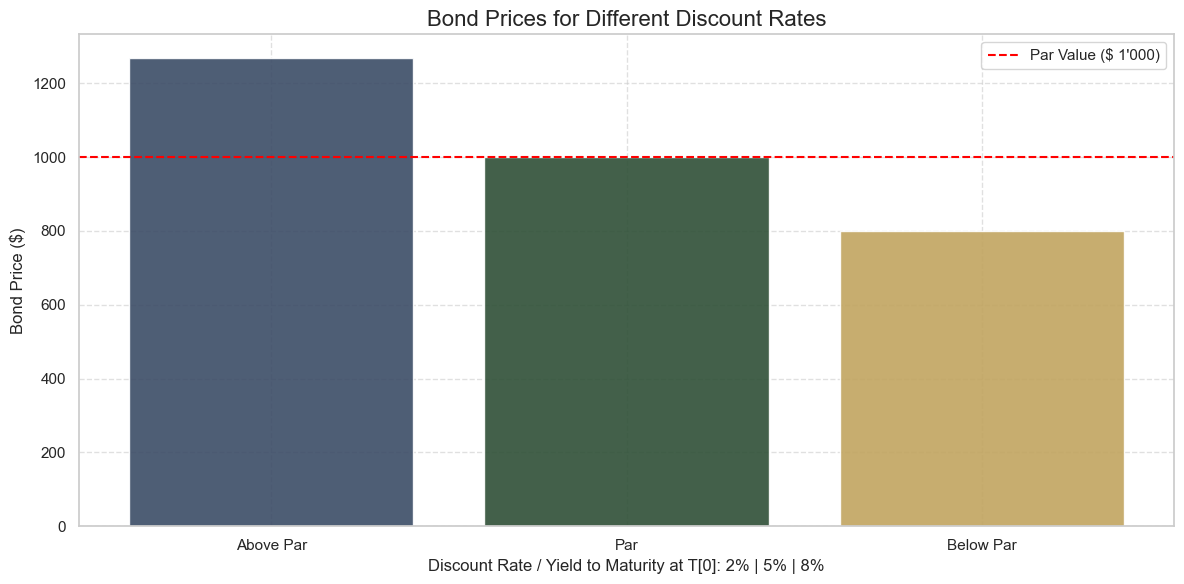

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ### Step 1: Define Cash Flow Table (from previous notebook)
def bond_cash_flows(face_value, coupon_rate, maturity, frequency):
    periods = int(maturity * frequency)
    coupon = face_value * coupon_rate / frequency
    cash_flows = [coupon] * periods
    cash_flows[-1] += face_value
    return pd.DataFrame({
        'Period': range(1, periods + 1),
        'Cash Flow': cash_flows
    })

# Bond parameters
face_value = 1000
coupon_rate = 0.05
maturity = 10
payment_frequency = 1
cash_flows = bond_cash_flows(face_value, coupon_rate, maturity, payment_frequency)

# ### Step 2: Define Discounting Function
def bond_price(cash_flows, discount_rate):
    """
    Calculate the present value (price) of a bond given its cash flows and discount rate.
    
    Parameters:
    - cash_flows: DataFrame containing periods and cash flows
    - discount_rate: Annual discount rate
    
    Returns:
    - Present value of the bond (price)
    """
    periods = cash_flows['Period']
    cash_flow_values = cash_flows['Cash Flow']
    return np.sum(cash_flow_values / (1 + discount_rate) ** periods)

# ### Step 3: Calculate Bond Prices for Below Par, Par, and Above Par
discount_rates = [0.02, 0.05, 0.08]  # below par, par, above par
prices = [bond_price(cash_flows, rate) for rate in discount_rates]

# Display Results
results = []
for rate, price in zip(discount_rates, prices):
    relation = "Below Par" if rate > coupon_rate else "Par" if rate == coupon_rate else "Above Par"
    results.append([rate * 100, price, relation])

df_results = pd.DataFrame(results, columns=["Discount Rate (%)", "Bond Price ($)", "Relationship"])
print(df_results)

# ### Step 4: Pull-to-Par Mechanism
def pull_to_par(cash_flows, discount_rate, years_to_maturity):
    """
    Simulate bond price evolution over time showing pull-to-par.
    
    Parameters:
    - cash_flows: DataFrame containing bond cash flows
    - discount_rate: Annual discount rate
    - years_to_maturity: List of years remaining to maturity
    
    Returns:
    - List of bond prices over time
    """
    prices = []
    for t in years_to_maturity:
        reduced_cash_flows = cash_flows[cash_flows['Period'] <= t].copy()
        reduced_cash_flows['Period'] -= (maturity - t) # Adjust periods
        prices.append(bond_price(reduced_cash_flows, discount_rate))
    return prices

# Simulate pull-to-par for a bond starting with a discount rate of 4% (Below Par)
remaining_years = list(range(maturity, 0, -1))
pull_to_par_prices = pull_to_par(cash_flows, 0.04, remaining_years)

# Visualize prices for below par, par, and above par
plt.bar(["Above Par", "Par", "Below Par"], prices, color=old_money_palette[:3], alpha=0.9)
plt.axhline(face_value, color='red', linestyle='--', label="Par Value ($ 1'000)")
plt.title("Bond Prices for Different Discount Rates", fontsize=16)
plt.ylabel("Bond Price ($)", fontsize=12)
plt.xlabel("Discount Rate / Yield to Maturity at T[0]: 2% | 5% | 8%", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 4. Amortization and Accretion

In fixed income analysis, the concepts of **amortization** and **accretion** explain how a bond’s book value evolves over time when the bond is purchased at a price different from par. These adjustments are particularly important in the context of **book valuation**, **interest income recognition**, and **regulatory accounting**.

When a bond is purchased at a price **above** or **below par**, the difference is systematically **amortized** or **accreted** over its remaining life, converging to par at maturity. This phenomenon is also referred to as the **pull-to-par effect**.

### Key Concepts

> **Premium Bond**: Purchased **above par**. The bond’s book value **declines** toward par over time — a process known as **amortization**.
> **Discount Bond**: Purchased **below par**. The bond’s book value **increases** toward par over time — a process known as **accretion**.
> **Par Bond**: No adjustment is necessary — price equals face value throughout.

Assuming the issuer does not default and market rates remain unchanged, the bond's price will approach par as the maturity date nears.

### Why It Matters

These accounting adjustments affect:

> The **book value** of fixed income holdings over time  
> The **effective yield** recognized by investors  
> The allocation of **interest income vs. capital gain/loss** in reporting & taxes.

### Numerical Examples (Based on Market Discount Rates)

Consider a 10-year, 5% annual coupon bond with a \$1,000 face value. Depending on market rates, the bond trades at different prices:

| Discount Rate (%) | Bond Price ($) | Bond Type     |
|-------------------|----------------|---------------|
| 2.0               | 1,269.48        | Premium       |
| 5.0               | 1,000.00        | Par           |
| 8.0               |   798.70        | Discount      |

> At a **2% market rate**, the bond trades **above par** due to its relatively high coupon. The excess value over par (\$269.48) will be **amortized** over 10 years.
> At **5%**, the bond trades at **par**. No amortization or accretion is needed.
> At an **8% market rate**, the bond trades **below par**. The bondholder receives low coupon payments relative to market demands, but this is compensated by **accretion** of the bond’s value from \$798.70 to \$1,000 at maturity.

### Straight-Line Accretion / Amortization Example

Using straight-line methods for simplicity, we can estimate the annual adjustment:

**Premium Bond at 2%:**

$$
\text{Annual Amortization} = \frac{1{,}269.48 - 1{,}000}{10} = 26.95
$$

**Discount Bond at 8%:**

$$
\text{Annual Accretion} = \frac{1{,}000 - 798.70}{10} = 20.13
$$

### Summary Table

| Bond Type      | Purchase Price | Trend to Par | Accounting Effect |
|----------------|----------------|--------------|-------------------|
| **Premium**    | Price > Par    | Amortizes ↓  | Reduces book value annually |
| **Par**        | Price = Par    | —            | No adjustment needed |
| **Discount**   | Price < Par    | Accretes ↑   | Increases book value annually |

Amortization and accretion are not just accounting formalities — they reflect how investors **earn or give up value** over time relative to the bond’s stated coupon. These mechanisms help ensure that **book yield converges with market yield**, preserving economic consistency in fixed income portfolios.

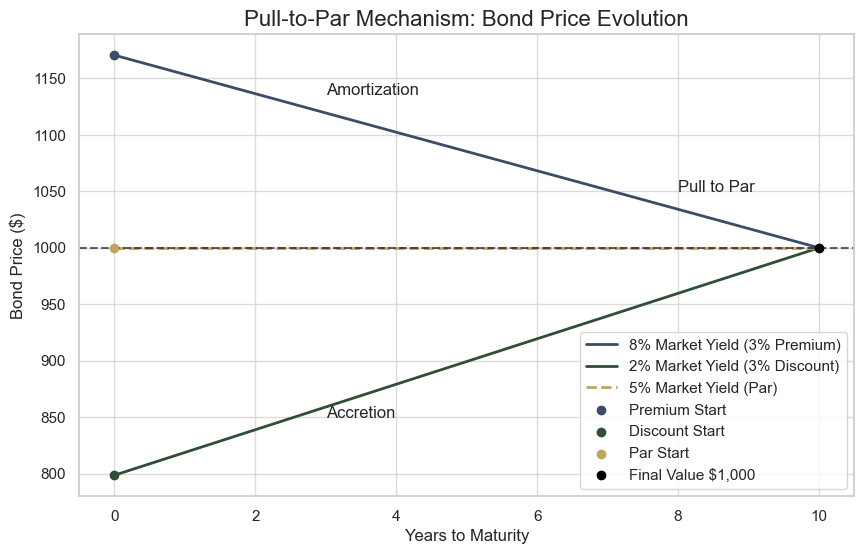

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Bond parameters
face_value = 1000
coupon_rate = 0.05
maturity = 10
payment_frequency = 1

# Define function to calculate bond prices based on cash flows
def bond_cash_flows(face_value, coupon_rate, maturity, frequency):
    periods = int(maturity * frequency)
    coupon = face_value * coupon_rate / frequency
    cash_flows = [coupon] * periods
    cash_flows[-1] += face_value  # Add face value to the last payment (at maturity)
    return pd.DataFrame({
        'Period': range(1, periods + 1),
        'Cash Flow': cash_flows
    })

def bond_price(cash_flows, discount_rate):
    """ Calculate the present value (price) of a bond given its cash flows and discount rate. """
    periods = cash_flows['Period']
    cash_flow_values = cash_flows['Cash Flow']
    return np.sum(cash_flow_values / (1 + discount_rate) ** periods)

cash_flows = bond_cash_flows(face_value, coupon_rate, maturity, payment_frequency)
premium_start = bond_price(cash_flows, 0.03)  # Bond priced at a 3% premium
par_start = bond_price(cash_flows, 0.05)  # Par value at 5% yield
discount_start = bond_price(cash_flows, 0.08)  # Bond priced at an 8% discount

years_to_maturity = np.arange(0, maturity + 1)

# Calculate the pull-to-par paths
premium_prices = premium_start - (premium_start - face_value) * (years_to_maturity / maturity)
discount_prices = discount_start + (face_value - discount_start) * (years_to_maturity / maturity)
par_prices = np.full_like(years_to_maturity, face_value)  # Par price remains constant

# Plot
plt.figure(figsize=(10, 6))
plt.plot(years_to_maturity, premium_prices, label="8% Market Yield (3% Premium)", linewidth=2)
plt.plot(years_to_maturity, discount_prices, label="2% Market Yield (3% Discount)", linewidth=2)
plt.plot(years_to_maturity, par_prices, label="5% Market Yield (Par)", linestyle="--", linewidth=2)
plt.axhline(face_value, color="black", linestyle="--", alpha=0.6)  # Par value line
plt.scatter(years_to_maturity[0], premium_prices[0], label="Premium Start", zorder=10)
plt.scatter(years_to_maturity[0], discount_prices[0], label="Discount Start", zorder=10)
plt.scatter(years_to_maturity[0], par_prices[0], label="Par Start", zorder=10)
plt.scatter(years_to_maturity[-1], par_prices[-1], color="black", label="Final Value $1,000", zorder=10)
# Annotations
plt.annotate("Pull to Par", xy=(maturity, face_value), xytext=(8, face_value + 50))
plt.annotate("Accretion", xy=(5, discount_prices[5]), xytext=(3, discount_prices[5] - 50))
plt.annotate("Amortization", xy=(5, premium_prices[5]), xytext=(3, premium_prices[5] + 50))
# Labels and title with enhanced explanations
plt.title("Pull-to-Par Mechanism: Bond Price Evolution", fontsize=16)
plt.xlabel("Years to Maturity", fontsize=12)
plt.ylabel("Bond Price ($)", fontsize=12)
plt.grid(alpha=0.7)
plt.legend()
plt.show()

## 5. Clean vs. Dirty Price
In bond markets, the quoted price of a bond often differs from the amount actually paid by the buyer. This distinction arises from **accrued interest**, which reflects the earned but unpaid coupon income between two coupon dates.

### Definitions
- **Clean Price**: The quoted price of the bond **excluding accrued interest**. This is the price used in bond listings and screen quotes.  
- **Dirty Price**: The **actual price paid** by the buyer, which includes the **clean price plus accrued interest**.

$$
\text{Dirty Price} = \text{Clean Price} + \text{Accrued Interest}
$$

The dirty price reflects the **total consideration** exchanged at settlement and is used for **cash flow and accounting purposes**.


### Accrued Interest (AI)
Between coupon dates, the bondholder earns interest on a daily basis. When a bond is sold before the next coupon payment, the seller is compensated for the accrued interest up to the settlement date.

The standard formula for accrued interest is:

$$
\text{AI} = \frac{\text{Coupon} \times \text{Days Since Last Payment}}{\text{Coupon Interval}}
$$

Where:
- **Coupon** is the periodic interest payment  
- **Days Since Last Payment** = number of days since last coupon (e.g. Jan 1 to Apr 1 = 90)  
- **Coupon Interval** = 365 (for annual bonds with Actual/Actual convention)

---

### Example: 5% Annual Coupon, 10-Year Bond
> Face Value = \$1,000  
> Coupon Rate = 5% annually → \$50 every year  
> Last coupon paid on **January 1**  
> Settlement date = **April 1** (90 days after)  
> Day count convention: **Actual/Actual**  
> Clean Price = \$980

Then:

$$
\text{AI} = \frac{50 \times 90}{365} = 12.33
$$

So the **dirty price** is:

$$
\text{Dirty Price} = 980 + 12.33 = 992.33
$$

### Why It Matters
- The **clean price** is used for quoting and tracking market value.  
- The **dirty price** is used in **settlement** and **total return** calculations.  
- Accrued interest ensures fairness in **ownership of earned income** between seller and buyer.

### Market Conventions
- Accrued interest is calculated according to specific **day count conventions** (e.g., 30/360, Actual/Actual).  
- Bonds quoted with a clean price convention include **Treasuries, corporates, and many sovereigns**.

Understanding the distinction between clean and dirty prices is essential for accurate **pricing**, **accounting**, and **performance attribution** in fixed income portfolios.

## 6. Yield to Maturity (YTM)

The **Yield to Maturity (YTM)** is a cornerstone concept in fixed income analysis. It represents the **internal rate of return (IRR)** of a bond — the single discount rate that makes the **present value of all future cash flows** equal to the bond’s current **market price**.

### Definition

Mathematically, YTM is the solution $y$ to the following equation:

$$
P = \sum_{i=1}^{n} \frac{CF_i}{(1 + y)^{t_i}}
$$

Where:
- $P$ = current bond price  
- $CF_i$ = cash flow at time $t_i$ (coupon or principal)  
- $y$ = yield to maturity (annualized)  
- $t_i$ = time in years until cash flow $i$  
- $n$ = total number of cash flows

This equation generally **cannot be solved analytically** and is computed numerically, for example using **Newton-Raphson iteration** or Excel's `IRR` function.

### Key Properties of YTM

- Expresses the **expected annual return** if the bond is held to maturity and all payments are made as scheduled.
- Assumes that **all coupon payments are reinvested** at the same rate $y$.
- Determines whether the bond trades at a **discount**, **par**, or **premium**:
  - If **YTM > coupon rate** → price < par (discount)
  - If **YTM = coupon rate** → price = par
  - If **YTM < coupon rate** → price > par (premium)



### Example: 10-Year 5% Bond

Let’s consider our standard bond:

- Face Value = \$1,000  
- Annual Coupon = 5% → \$50 per year  
- Maturity = 10 years  
- Market Price = \$920

We want to find the yield $y$ that satisfies:

$$
920 = \sum_{t=1}^{9} \frac{50}{(1 + y)^t} + \frac{1{,}050}{(1 + y)^{10}}
$$

This equation is typically solved numerically. The solution is:

$$
y \approx 6.27\%
$$

This means the investor will earn an **annualized return of approximately 6.27%** if the bond is held to maturity, all cash flows are received on time, and coupons are reinvested at the same yield.

### Intuition

Think of YTM as the bond’s **internal rate of return**, which equates the price you pay today to the present value of all future cash flows.

>It is a unifying measure that allows investors to compare bonds of **different coupons, maturities, and prices** on a common basis.

### Practical Use

YTM is used to:
- **Value fixed income securities**
- **Compare bonds** across issuers and structures
- **Assess return expectations**, given current market conditions
- **Anchor risk metrics** like duration and convexity

### Important Caveats

- YTM assumes **no default** or prepayment risk.
- It also assumes **reinvestment of coupons at the YTM**, which may not reflect actual reinvestment opportunities.
- For callable or amortizing bonds, **yield to call** or **yield to worst** may be more appropriate.

Despite its limitations, YTM remains a foundational tool in bond valuation and portfolio construction.


In [8]:
import numpy as np
from scipy.optimize import newton

def bond_ytm(price, face_value, coupon_rate, years_to_maturity, freq=1):
    """
    Calculate Yield to Maturity (YTM) of a bond.

    Parameters:
    - price: Market price of the bond
    - face_value: Face value of the bond (e.g., 1000)
    - coupon_rate: Annual coupon rate (e.g., 0.05 for 5%)
    - years_to_maturity: Years remaining until maturity
    - freq: Coupon frequency per year (1 = annual, 2 = semi-annual)

    Returns:
    - Yield to Maturity
    """
    periods = int(years_to_maturity * freq)
    coupon = coupon_rate * face_value / freq

    def bond_price_function(y):
        return sum([coupon / (1 + y / freq)**t for t in range(1, periods + 1)]) + face_value / (1 + y / freq)**periods - price

    # Initial guess: coupon rate
    return newton(bond_price_function, x0=coupon_rate)

# Example usage:
price = 1000  # market price
face_value = 1000
coupon_rate = 0.05
years_to_maturity = 10

ytm = bond_ytm(price, face_value, coupon_rate, years_to_maturity)
print(f"Yield to Maturity: {ytm:.4%}")

Yield to Maturity: 5.0000%


## 7. Duration and Convexity

In fixed income analysis, **duration and convexity** are core tools to quantify how bond prices respond to interest rate changes. **Duration** measures the linear (first-order) sensitivity of a bond’s price to yield changes. **Convexity** adjusts this estimate for curvature (second-order effects), improving accuracy, especially for larger rate moves.

To understand **why** these approximations work, we turn to **Taylor series** and **calculus**. The bond price function \( P(y) \), which depends on the yield \( y \), can be expanded as:

$$
P(y + \Delta y) \approx P(y) + \frac{dP}{dy} \Delta y + \frac{1}{2} \frac{d^2P}{dy^2} (\Delta y)^2 + \cdots
$$

This shows that **modified duration** and **convexity** correspond to the **first** and **second derivatives** of the bond price function with respect to yield. These tools allow us to approximate price changes due to yield movements without revaluing the bond from scratch.

### Example Bond

We use the following bond throughout this section:

- Face Value = \$1,000  
- Annual Coupon = 5% → \$50/year  
- Maturity = 10 years  
- Yield to Maturity (YTM) = 5% (annual compounding)  
- Price = \$1,000 (trades at par)

### Table for Duration and Convexity

| Year ($t$) | Cash Flow ($CF_t$) | PV Factor $(1 + y)^{-t}$ | PV of CF | Weight $= \frac{PV}{P}$ | $t \cdot \text{Weight}$ | $t(t+1) \cdot CF_t$ | $(1 + y)^{-t-2}$ | Convexity Term |
|------------|--------------------|---------------------------|----------|--------------------------|--------------------------|----------------------|------------------|----------------|
| 1          | 50                 | 0.9524                    | 47.62    | 0.0476                   | 0.0476                   | 100                  | 0.8610           | 86.10          |
| 2          | 50                 | 0.9070                    | 45.35    | 0.0454                   | 0.0908                   | 300                  | 0.8190           | 245.70         |
| 3          | 50                 | 0.8638                    | 43.19    | 0.0432                   | 0.1296                   | 600                  | 0.7788           | 467.28         |
| 4          | 50                 | 0.8227                    | 41.13    | 0.0411                   | 0.1645                   | 1000                 | 0.7407           | 740.66         |
| 5          | 50                 | 0.7835                    | 39.18    | 0.0392                   | 0.1959                   | 1500                 | 0.7046           | 1,056.90       |
| 6          | 50                 | 0.7462                    | 37.31    | 0.0373                   | 0.2239                   | 2100                 | 0.6702           | 1,407.39       |
| 7          | 50                 | 0.7107                    | 35.54    | 0.0355                   | 0.2483                   | 2800                 | 0.6376           | 1,785.28       |
| 8          | 50                 | 0.6768                    | 33.84    | 0.0338                   | 0.2702                   | 3600                 | 0.6065           | 2,183.40       |
| 9          | 50                 | 0.6446                    | 32.23    | 0.0322                   | 0.2898                   | 4500                 | 0.5776           | 2,599.20       |
| 10         | 1050               | 0.6139                    | 644.60   | 0.6446                   | 6.4455                   | 115,500              | 0.5506           | 63,368.30      |
| **Total**  |                    |                           | 1000.00  | 1.0000                   | **8.1059**               |                      |                  | **75.00**      |

### Step 1: Macaulay Duration

Macaulay duration is the **weighted average time** until the bond's cash flows are received:

$$
D_{\text{Mac}} = \sum_{t=1}^{n} t \cdot \frac{PV(CF_t)}{P} = 8.11 \text{ years}
$$

### Step 2: Modified Duration

Modified duration adjusts for the compounding effect of yields and gives an estimate of the **percentage price change** for a small change in yield:

$$
D_{\text{mod}} = \frac{D_{\text{Mac}}}{1 + y} = \frac{8.11}{1.05} = 7.72
$$

Note: This definition assumes **discrete annual compounding**. Under **continuous compounding**, we also have:

$$
D_{\text{mod}} = -\frac{1}{P} \cdot \frac{dP}{dy}
$$

### Step 3: Convexity

Convexity measures the **curvature** of the price–yield relationship and improves the accuracy of price change estimates for larger yield changes:

$$
\text{Convexity} = \frac{1}{P} \sum_{t=1}^{n} \frac{CF_t \cdot t(t + 1)}{(1 + y)^{t + 2}} \quad \text{(assumes annual compounding)}
$$

Example:

$$
\text{Convexity} = \frac{73{,}950.20}{1{,}000} = 75.00
$$

This is also equal to:

$$
\text{Convexity} = \frac{1}{P} \cdot \frac{d^2P}{dy^2}
$$

### Step 4: Price Change Approximation

Using a second-order Taylor expansion:

$$
\frac{\Delta P}{P} \approx -D_{\text{mod}} \cdot \Delta y + \frac{1}{2} \cdot \text{Convexity} \cdot (\Delta y)^2
$$

For a 100 basis point increase in yield ($\Delta y = 0.01$):

$$
\frac{\Delta P}{P} \approx -7.72 \cdot 0.01 + \frac{1}{2} \cdot 75.00 \cdot (0.01)^2 = -0.0772 + 0.00375 = -0.07345
$$

→ This implies a **7.35% price drop**, less severe than the 7.72% drop predicted by modified duration alone.

### Summary: Risk Metrics of the 10-Year 5% Bond (YTM = 5%)

| Measure              | Value      | Interpretation                                                 |
|----------------------|------------|----------------------------------------------------------------|
| Macaulay Duration    | 8.11 years | Weighted average time until cash flows                         |
| Modified Duration    | 7.72       | Approx. % price change per 1% yield change (linear estimate)   |
| Convexity            | 75.00      | Second-order adjustment — improves accuracy for larger moves   |
| Est. Price Change    | –7.35%     | Estimated change for +100 bps yield increase                   |

### Final Notes

> The **Taylor series** allows us to express bond price sensitivity using calculus.  
> **Modified duration** captures the slope (first-order effect).  
> **Convexity** adjusts for curvature (second-order effect), especially relevant for large $\Delta y$.  
> These tools are essential for **hedging, stress testing, and risk budgeting** in fixed income portfolio management.

<img src="Macauly_Duration.png" width="50%" align="" />

In [9]:
import numpy as np

def duration_convexity(face, coupon_rate, maturity, freq, ytm):
    periods = int(maturity * freq)
    coupon = face * coupon_rate / freq
    times = np.arange(1, periods + 1)
    cf = np.full(periods, coupon)
    cf[-1] += face
    df = 1 / (1 + ytm / freq) ** times
    pv = cf * df
    bond_pv = pv.sum()

    # Time in years
    t = times / freq
    macaulay_duration = np.sum(t * pv) / bond_pv
    modified_duration = macaulay_duration / (1 + ytm / freq)

    # convexity formula
    convexity = np.sum(cf * t * (t + 1 / freq) / (1 + ytm / freq) ** (t * freq + 2)) / bond_pv

    return bond_pv, modified_duration, convexity

def price_bond(face, coupon_rate, maturity, freq, ytm):
    periods = int(maturity * freq)
    coupon = face * coupon_rate / freq
    times = np.arange(1, periods + 1)
    df = 1 / (1 + ytm / freq) ** times
    cf = np.full(periods, coupon)
    cf[-1] += face
    return np.sum(cf * df)

# Inputs
face_value = 1000
coupon_rate = 0.05
maturity = 10
freq = 1
ytm = 0.05
delta_y = 0.01  # +1% yield shift

# 1. Original metrics
price_orig, mod_dur, conv = duration_convexity(face_value, coupon_rate, maturity, freq, ytm)

# 2. Estimate price change using Modified Duration
price_dur = price_orig * (1 - mod_dur * delta_y)

# 3. Estimate price change using Duration + Convexity
price_dur_conv = price_orig * (1 - mod_dur * delta_y + 0.5 * conv * delta_y ** 2)

# 4. Reprice bond at new YTM (ytm + delta_y)
price_new = price_bond(face_value, coupon_rate, maturity, freq, ytm + delta_y)

# 5. Print all results
print(f"Modified Duration: {mod_dur:.2f} | Convexity: {conv:.2f}")
print(f"Original Price: {price_orig:.2f}")
print(f"Price using Modified Duration: {price_dur:.2f}")
print(f"Price using Duration + Convexity: {price_dur_conv:.2f}")
print(f"Actual Repriced Bond (new YTM = {ytm + delta_y:.2%}): {price_new:.2f}")

# Show differences
print(f"\nDifferences to true price after +1% yield:")
print(f"- Mod. Duration error: {price_dur - price_new:.2f}")
print(f"- Mod. Duration + Convexity error: {price_dur_conv - price_new:.2f}")

Modified Duration: 7.72 | Convexity: 75.00
Original Price: 1000.00
Price using Modified Duration: 922.78
Price using Duration + Convexity: 926.53
Actual Repriced Bond (new YTM = 6.00%): 926.40

Differences to true price after +1% yield:
- Mod. Duration error: -3.62
- Mod. Duration + Convexity error: 0.13


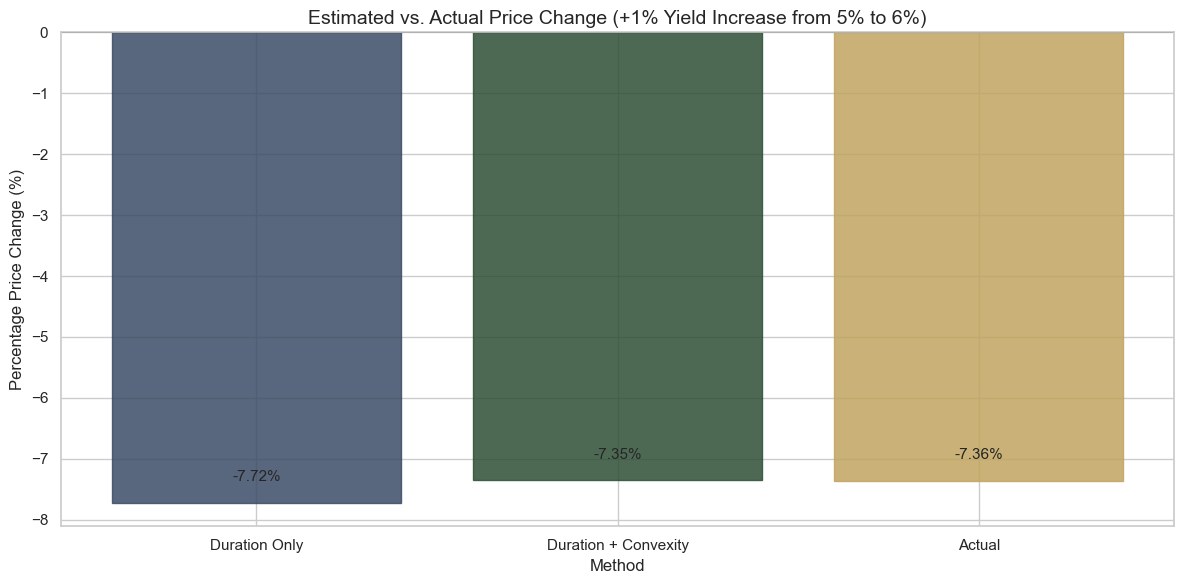

Macaulay Duration: 8.1078 years
Modified Duration: 7.7217
Convexity: 74.9977

Duration-only Estimate: -7.7217%
Duration + Convexity Estimate: -7.3467%
Actual Price Change (from discounting): -7.3601%

Duration-only Error: -0.3616%
Duration + Convexity Error: 0.0133%


In [10]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Bond parameters
face_value = 1000
coupon_rate = 0.05
maturity = 10
payment_frequency = 1

# Generate bond cash flows function
def bond_cash_flows(face_value, coupon_rate, maturity, frequency):
    periods = int(maturity * frequency)
    coupon = face_value * coupon_rate / frequency
    cash_flows = [coupon] * periods
    cash_flows[-1] += face_value  # Add face value to last period
    return pd.DataFrame({
        'Period': range(1, periods + 1),
        'Cash Flow': cash_flows
    })

# Bond price function
def bond_price(cash_flows, discount_rate):
    periods = cash_flows['Period']
    cash_flow_values = cash_flows['Cash Flow']
    return np.sum(cash_flow_values / (1 + discount_rate) ** periods)

# Calculate Macaulay duration
def macaulay_duration(cash_flows, discount_rate):
    periods = cash_flows['Period']
    cash_flow_values = cash_flows['Cash Flow']
    discounted_cash_flows = cash_flow_values / (1 + discount_rate) ** periods
    weighted_time = periods * discounted_cash_flows
    return np.sum(weighted_time) / np.sum(discounted_cash_flows)

# Calculate Modified Duration
def modified_duration(macaulay_duration, discount_rate):
    return macaulay_duration / (1 + discount_rate)

# Calculate convexity
def convexity(cash_flows, discount_rate):
    periods = cash_flows['Period']
    cash_flow_values = cash_flows['Cash Flow']
    pv_factors = (1 + discount_rate) ** (periods + 2)
    convexity_terms = cash_flow_values * periods * (periods + 1) / pv_factors
    price = bond_price(cash_flows, discount_rate)
    return np.sum(convexity_terms) / price

# Bond cash flows
cash_flows = bond_cash_flows(face_value, coupon_rate, maturity, payment_frequency)

# Baseline YTM and price
par_rate = 0.05
par_price = bond_price(cash_flows, par_rate)

# Duration and convexity at par
D_mac = macaulay_duration(cash_flows, par_rate)
D_mod = modified_duration(D_mac, par_rate)
C = convexity(cash_flows, par_rate)

# Yield change
new_yield = 0.06
delta_y = new_yield - par_rate

# Estimates
duration_only_change = -D_mod * delta_y * 100
convexity_correction = 0.5 * C * (delta_y ** 2) * 100
duration_convexity_change = duration_only_change + convexity_correction

# Actual price change
new_price = bond_price(cash_flows, new_yield)
actual_change = (new_price - par_price) / par_price * 100

# Error
duration_error = duration_only_change - actual_change
duration_convexity_error = duration_convexity_change - actual_change

# Plot
methods = ["Duration Only", "Duration + Convexity", "Actual"]
values = [duration_only_change, duration_convexity_change, actual_change]

bars = plt.bar(methods, values, alpha=0.85)

for bar, color in zip(bars, old_money_palette):
    bar.set_color(color)

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
             f"{val:.2f}%", ha='center', va='bottom', fontsize=11)

plt.title("Estimated vs. Actual Price Change (+1% Yield Increase from 5% to 6%)", fontsize=14)
plt.ylabel("Percentage Price Change (%)", fontsize=12)
plt.xlabel("Method", fontsize=12)
plt.axhline(0, color="black", linewidth=0.7)
plt.tight_layout()
plt.show()

# Print summary for students
print(f"Macaulay Duration: {D_mac:.4f} years")
print(f"Modified Duration: {D_mod:.4f}")
print(f"Convexity: {C:.4f}")
print()
print(f"Duration-only Estimate: {duration_only_change:.4f}%")
print(f"Duration + Convexity Estimate: {duration_convexity_change:.4f}%")
print(f"Actual Price Change (from discounting): {actual_change:.4f}%")
print()
print(f"Duration-only Error: {duration_error:.4f}%")
print(f"Duration + Convexity Error: {duration_convexity_error:.4f}%")

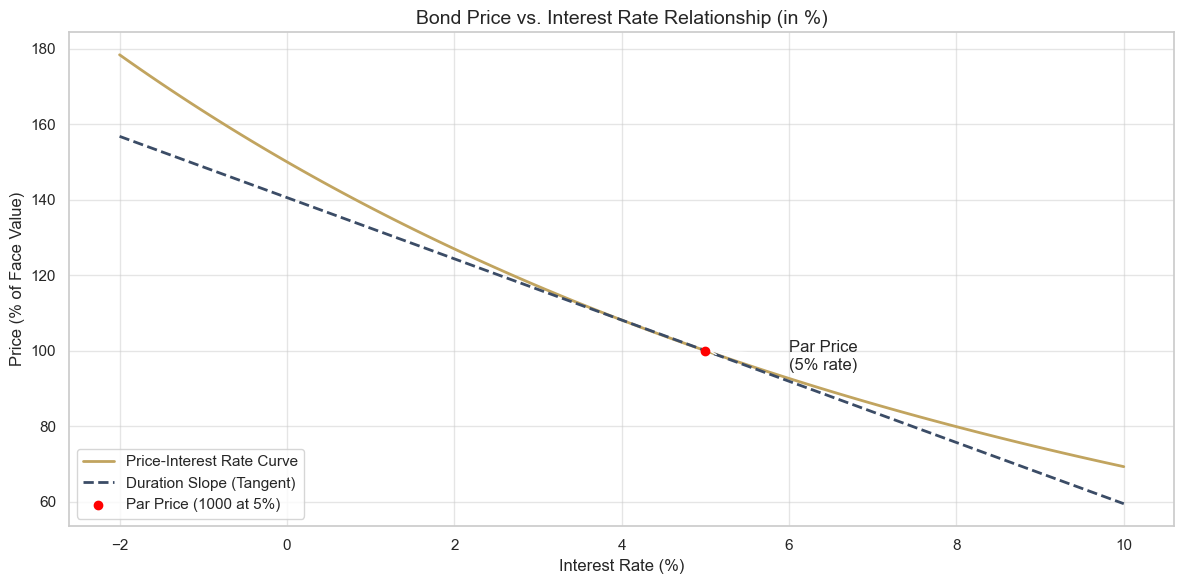

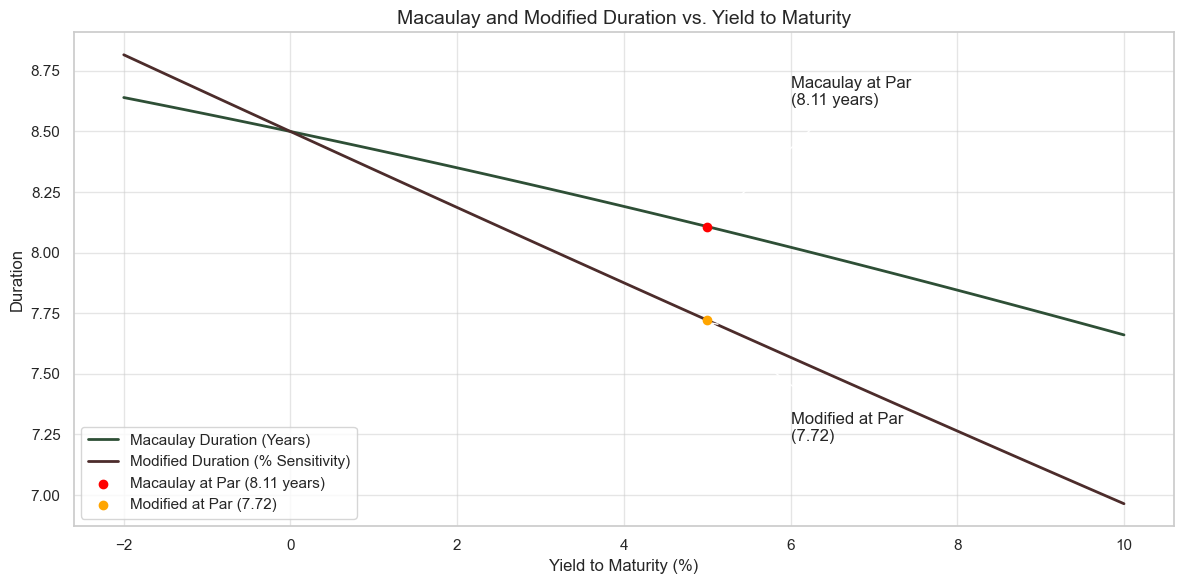

Macaulay Duration at Par (5% rate): 8.11 years
Modified Duration at Par (5% rate): 7.72


In [11]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define bond parameters and functions
face_value = 1000
coupon_rate = 0.05
maturity = 10
payment_frequency = 1

def bond_cash_flows(face_value, coupon_rate, maturity, frequency):
    periods = int(maturity * frequency)
    coupon = face_value * coupon_rate / frequency
    cash_flows = [coupon] * periods
    cash_flows[-1] += face_value
    return pd.DataFrame({
        'Period': range(1, periods + 1),
        'Cash Flow': cash_flows
    })

def bond_price(cash_flows, discount_rate):
    periods = cash_flows['Period']
    cash_flow_values = cash_flows['Cash Flow']
    return np.sum(cash_flow_values / (1 + discount_rate) ** periods)

def macaulay_duration(cash_flows, discount_rate):
    periods = cash_flows['Period']
    cash_flow_values = cash_flows['Cash Flow']
    discounted_cash_flows = cash_flow_values / (1 + discount_rate) ** periods
    weighted_time = periods * discounted_cash_flows
    return np.sum(weighted_time) / np.sum(discounted_cash_flows)

def modified_duration(macaulay_dur, discount_rate):
    return macaulay_dur / (1 + discount_rate)

# Generate bond cash flows
cash_flows = bond_cash_flows(face_value, coupon_rate, maturity, payment_frequency)

# Interest rates and bond pricing
interest_rates = np.linspace(-0.02, 0.10, 100)
prices = [bond_price(cash_flows, rate) for rate in interest_rates]

# Par rate and duration
par_rate = 0.05
par_price = bond_price(cash_flows, par_rate)
duration_at_par = macaulay_duration(cash_flows, par_rate)
mod_duration_at_par = modified_duration(duration_at_par, par_rate)
tangent_line = par_price - duration_at_par * face_value * (interest_rates - par_rate)

# Plot bond price vs interest rate
plt.figure()
sns.lineplot(x=interest_rates * 100, y=np.array(prices) / face_value * 100, 
             label="Price-Interest Rate Curve", color=old_money_palette[2], linewidth=2)
sns.lineplot(x=interest_rates * 100, y=tangent_line / face_value * 100, 
             label="Duration Slope (Tangent)", color=old_money_palette[0], linestyle="--", linewidth=2)
plt.scatter(par_rate * 100, par_price / face_value * 100, color="red", label="Par Price (1000 at 5%)", zorder=10)
plt.annotate("Par Price\n(5% rate)", xy=(par_rate * 100, par_price / face_value * 100), 
             xytext=(par_rate * 100 + 1, par_price / face_value * 100 - 5),
             arrowprops=dict(facecolor="black", arrowstyle="->"))
plt.title("Bond Price vs. Interest Rate Relationship (in %)", fontsize=14)
plt.xlabel("Interest Rate (%)", fontsize=12)
plt.ylabel("Price (% of Face Value)", fontsize=12)
plt.legend(loc="lower left")
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# Compute durations across interest rate range
macaulay_durations = [macaulay_duration(cash_flows, rate) for rate in interest_rates]
modified_durations = [modified_duration(md, rate) for md, rate in zip(macaulay_durations, interest_rates)]

# Plot duration curves
sns.lineplot(x=interest_rates * 100, y=macaulay_durations, label="Macaulay Duration (Years)", color=old_money_palette[1], linewidth=2)
sns.lineplot(x=interest_rates * 100, y=modified_durations, label="Modified Duration (% Sensitivity)", color=old_money_palette[5], linewidth=2)
plt.scatter(par_rate * 100, duration_at_par, color="red", label=f"Macaulay at Par ({duration_at_par:.2f} years)", zorder=10)
plt.scatter(par_rate * 100, mod_duration_at_par, color="orange", label=f"Modified at Par ({mod_duration_at_par:.2f})", zorder=10)
plt.annotate(f"Macaulay at Par\n({duration_at_par:.2f} years)", 
             xy=(par_rate * 100, duration_at_par), 
             xytext=(par_rate * 100 + 1, duration_at_par + 0.5),
             arrowprops=dict(facecolor="black", arrowstyle="->"))
plt.annotate(f"Modified at Par\n({mod_duration_at_par:.2f})", 
             xy=(par_rate * 100, mod_duration_at_par), 
             xytext=(par_rate * 100 + 1, mod_duration_at_par - 0.5),
             arrowprops=dict(facecolor="black", arrowstyle="->"))
plt.title("Macaulay and Modified Duration vs. Yield to Maturity", fontsize=14)
plt.xlabel("Yield to Maturity (%)", fontsize=12)
plt.ylabel("Duration", fontsize=12)
plt.legend(loc="lower left")
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# Print results
print(f"Macaulay Duration at Par (5% rate): {duration_at_par:.2f} years")
print(f"Modified Duration at Par (5% rate): {mod_duration_at_par:.2f}")


## 8. Yield Curve Construction in Fixed Income

In fixed income analysis, the **term structure of interest rates** is the foundation for pricing, hedging, and risk management of bonds and interest rate derivatives. Multiple yield curves exist — each serving different analytical and practical purposes.

In markets like the U.S. Treasury market:
- You observe (derive) actual **yield to maturity (YTM)** for bonds across different maturities
- These **observed YTMs** are interpreted directly as **par yields**

> This is how Bloomberg’s `YCGT0025 Index` (U.S. Treasury Par Yield Curve) is built:
> - **T-bills** for short maturities  
> - **Notes and bonds** for longer maturities  
> - Based on **on-the-run** securities (most recently issued)

We use public available data from an iShares U.S. Treasury Bond ETF (GOVT):
https://www.ishares.com/us/products/239468/ishares-u-s-treasury-bond-etf

You can download holdings data from the iShares website, see Detailed Holdings and Analytics https://www.ishares.com/us/products/239468/detailed-holdings-and-analytics

### 1. Observed Yield Curve (YTW/YTM)

The **observed yield curve** is built from **quoted yields** of traded bonds. For non-callable U.S. Treasury bonds, the **Yield to Maturity (YTM)** is the internal rate of return $y$ solving:

$$
P = \sum_{i=1}^{N} \frac{C}{(1 + y)^i} + \frac{F}{(1 + y)^N}
$$

Where:
- $P$ = market price  
- $C$ = semiannual coupon payment  
- $F$ = face value (usually 100)  
- $N$ = number of periods to maturity

This curve reflects market pricing but is **not arbitrage-free**. It is often **noisy** due to:
- Liquidity or credit premia  
- Discount/premium pricing  
- Market imperfections

Observed curves are typically **smoothed** using non-parametric regressions like **LOWESS** for visualization.

### Step 1 -  Import and Clean U.S. Treasury Bond Data

We begin by importing a dataset representing the holdings of a U.S. Treasury bond ETF.

Key cleaning steps:
> - Strip out headers and metadata
> - Convert all numerical fields properly
> - Parse `Maturity` and compute **Time to Maturity (TTM)**
> - Ensure all datatypes are numeric or datetime, avoiding object types## Step 1: Load and Clean Data

We start by loading the U.S. Treasury holdings data from an ETF and cleaning relevant numeric and date columns.


In [12]:
# Set the date
from datetime import datetime
eval_date = datetime(2025, 4,23)
print(eval_date)

2025-04-23 00:00:00


In [13]:
import pandas as pd
# Unfortunately the xls from iShares is a bit messy. I have pre-cleaned the xlsx to csv...

# Load data
csv_file_path = f'{PATH_TO_CSV_FILES}iShares-US-Treasury-Bond-ETF_fund_20250423.csv'
df_raw = pd.read_csv(csv_file_path)
df_full = df_raw.iloc[7:].copy()
df_full.columns = df_raw.iloc[6]
df_full.reset_index(drop=True, inplace=True)

# Clean numeric values
def clean_number(x):
    try:
        return float(str(x).replace("’", "").replace(",", "").strip()) if str(x).strip() not in ["--", ""] else None
    except:
        return None

numeric_cols = [
    "Market Value", "Weight (%)", "Notional Value", "Par Value", "Price", "Coupon (%)",
    "Yield to Worst (%)", "Mod. Duration", "Real Duration", "Real YTM (%)", 
    "YTM (%)", "FX Rate", "Duration"
]
for col in numeric_cols:
    if col in df_full.columns:
        df_full[col] = df_full[col].map(clean_number)

# Convert date columns
for col in ["Maturity", "Accrual Date", "Effective Date"]:
    if col in df_full.columns:
        df_full[col] = pd.to_datetime(df_full[col], errors="coerce")

# Fix: fill missing Effective Date with Accrual Date
df_full["Effective Date"] = df_full["Effective Date"].fillna(df_full["Accrual Date"])

# Compute time-related columns
df_full["Time to Maturity"] = (df_full["Maturity"] - eval_date).dt.days / 365.25
df_full["Bond Age (Years)"] = (eval_date - df_full["Effective Date"]).dt.days / 365.25

# Filter out invalid rows (e.g., cash positions, missing key values)
df_full = df_full[~df_full["Name"].str.contains("Cash|CSH FND", na=False)]
df_full = df_full.dropna(subset=["Time to Maturity", "Yield to Worst (%)", "Weight (%)", "Effective Date"])

# Preview key columns
df_full[["Name", "Price", "Coupon (%)", "Yield to Worst (%)", "Time to Maturity", "Bond Age (Years)"]].dropna().head()


6,Name,Price,Coupon (%),Yield to Worst (%),Time to Maturity,Bond Age (Years)
0,TREASURY NOTE,84.01,1.38,4.19,6.562628,3.436003
1,TREASURY NOTE,97.36,3.13,3.93,3.564682,6.436687
2,TREASURY NOTE,95.38,2.63,3.94,3.816564,6.184805
3,TREASURY NOTE,97.04,2.75,3.87,2.814511,7.184120
4,TREASURY NOTE,97.13,2.25,3.90,1.815195,8.183436


### Step 2 - Plot The Observed Yield Curve

We visualize `Yield to Worst (%)` against `Time to Maturity`.  
This empirical curve serves as a noisy version of the par yield curve and exhibits jumps and local irregularities.

> Use **YTW** vs. **Time to Maturity**

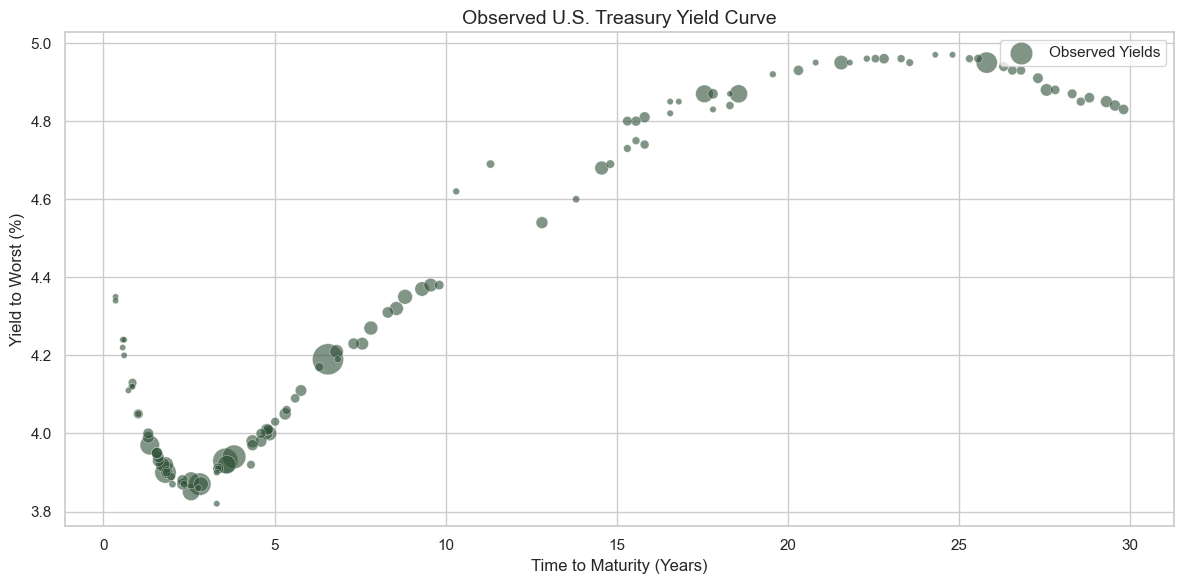

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot
sns.scatterplot(
    data=df_full,
    x="Time to Maturity",
    y="Yield to Worst (%)",
    size=df_full["Weight (%)"] * 100,
    sizes=(20, 500),
    legend=False,
    alpha=0.6,
    color=old_money_palette[1],
    label="Observed Yields"
)

# Labels and legend
plt.title("Observed U.S. Treasury Yield Curve", fontsize=14)
plt.xlabel("Time to Maturity (Years)", fontsize=12)
plt.ylabel("Yield to Worst (%)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


### Why Is There a Gap in the U.S. Yield Curve Between Intermediate and Long Maturities?

The visible gap in the U.S. Treasury yield curve — particularly between the 10-year and 15-year maturities — is a result of both **historical issuance policies** and **market structure**.

Timeline of Key U.S. Treasury Decisions
| Year | Event                           |
|------|---------------------------------|
| 1986 | 20-year bonds discontinued      |
| 2001 | 30-year bonds suspended         |
| 2006 | 30-year bonds reintroduced      |
| 2020 | 20-year bonds reintroduced      |

#### The Math Behind the Gap:
- A long period with **no 20Y issuance** between **2006 and 2020**
- Bonds issued in 2006 with a 30-year maturity are now drifting into the **11–14Y range**.
- As a result, the 10–15Y segment is populated by **old off-the-run 30Y bonds** that are **illiquid and rarely used for pricing**.
- Lack of benchmark bonds maturing in that segment today
- This creates a **natural gap** in observed yields, even though theoretical models interpolate across it.

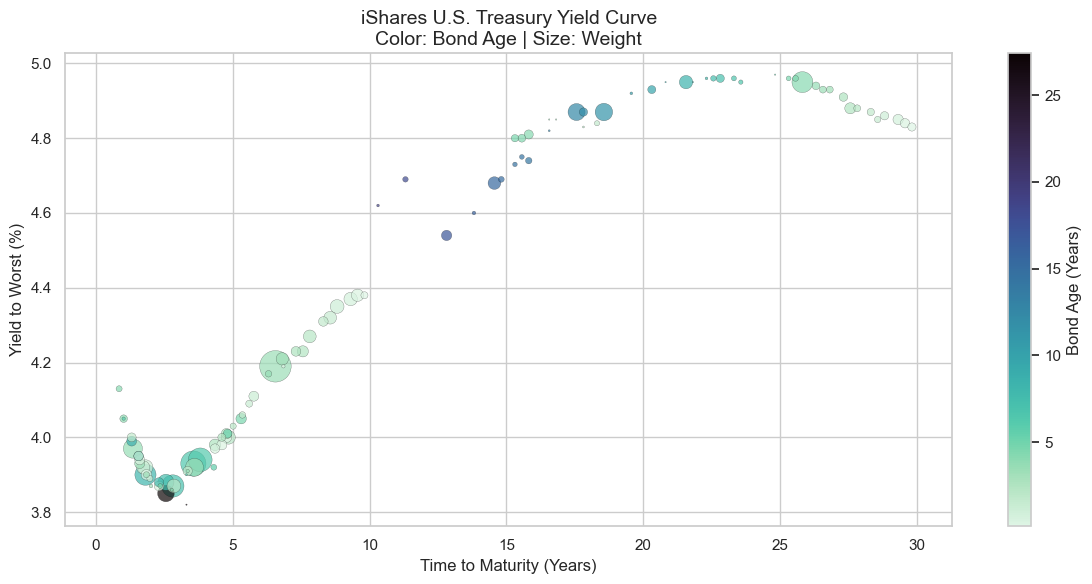

count    116.000000
mean      10.855744
std        9.504518
min        0.355921
25%        2.510609
50%        6.833676
75%       18.310746
max       29.815195
Name: Time to Maturity, dtype: float64


In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib import cm

df_plot = df_full.dropna(subset=["Yield to Worst (%)", "Time to Maturity", "Time to Maturity", "Weight (%)"]).copy()

x = df_plot["Time to Maturity"]
y = df_plot["Yield to Worst (%)"]
age = df_plot["Bond Age (Years)"]
size = df_plot["Weight (%)"] * 100  # Adjust scaling if needed

norm = mcolors.Normalize(vmin=age.min(), vmax=age.max())
cmap = plt.colormaps.get_cmap("mako_r")
colors = cmap(norm(age))

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=colors, s=size, alpha=0.7, edgecolor="k", linewidth=0.2)

ax.set_title("iShares U.S. Treasury Yield Curve\nColor: Bond Age | Size: Weight", fontsize=14)
ax.set_xlabel("Time to Maturity (Years)")
ax.set_ylabel("Yield to Worst (%)")
ax.grid(True)

# Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Bond Age (Years)")

plt.tight_layout()
plt.show()

# Optional: Summary stats
print(df_plot["Time to Maturity"].describe())


**Try Quadratic Interpolation (But Not Ideal...)**

Quadratic interpolation can create artificial spikes when the yield curve has kinks or irregular spacing.

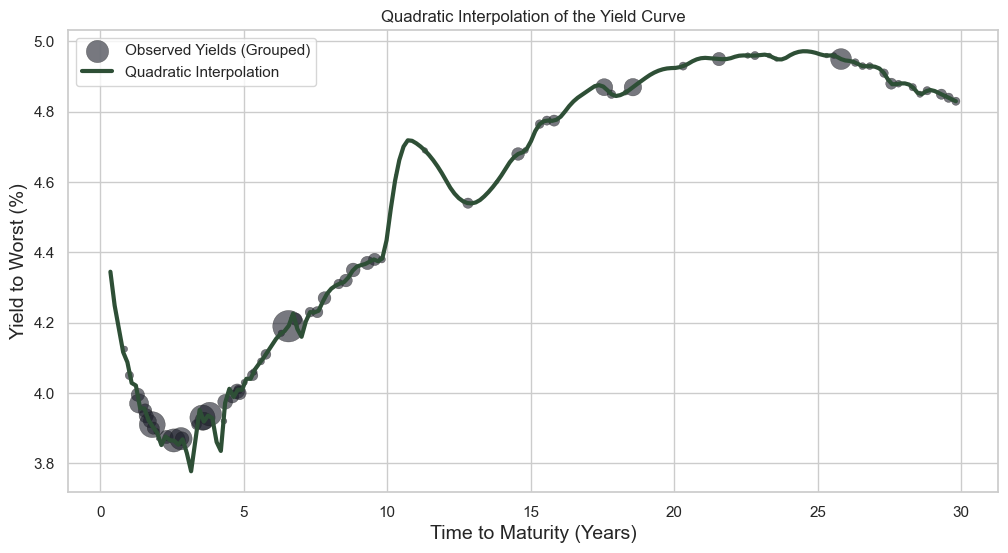

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Prepare data
df_grouped = df_full.dropna(subset=["Yield to Worst (%)", "Time to Maturity", "Weight (%)"]) \
    .groupby("Time to Maturity").agg({
        "Yield to Worst (%)": "mean",
        "Weight (%)": "sum"
    }).reset_index()

x_vals = df_grouped["Time to Maturity"].values
y_vals = df_grouped["Yield to Worst (%)"].values
sizes = df_grouped["Weight (%)"].values * 100

# Interpolation function (quadratic)
interp_func = interp1d(
    x_vals, y_vals,
    kind="quadratic",
    fill_value="extrapolate"
)
grid_times = np.linspace(min(x_vals), max(x_vals), 200)
grid_yields = interp_func(grid_times)

# Plot
plt.scatter(x_vals, y_vals, s=sizes, color="#1C1F2A", alpha=0.6, edgecolor="k", linewidth=0.3, label="Observed Yields (Grouped)")
plt.plot(grid_times, grid_yields, color="#2E4F36", linewidth=3, label="Quadratic Interpolation")
plt.title("Quadratic Interpolation of the Yield Curve")
plt.xlabel("Time to Maturity (Years)", fontsize=14)
plt.ylabel("Yield to Worst (%)", fontsize=14)
plt.legend()
plt.show()

#### LOWESS Smoothing for a Clean Curve
LOWESS is a smoother, not an interpolator. 
But we can still interpolate from the fitted curve to query any tenor. 
We introduce - `threshold_age` to filter out bonds that are too old.

In [17]:
# Filters
threshold_age = 99 # This filters out bonds that are too old --> 99 we use the full sample available
data_frac = 0.15 # Between 0 and 1. The fraction of the data used when estimating each y-value
threshold_time_to_maturity = np.max(df_full["Time to Maturity"])
threshold_par_value = 1 # If we want to exclude small bonds

# Rearrange DataFrame for "Actives"
# Identify STRIPs explicitly
df_strips = df_full[df_full["Name"].str.contains("STRIP", case=False, na=False)].copy()

# Define off-the-run bonds
df_offtherun = df_full[
    (df_full["Bond Age (Years)"] > threshold_age) &
    (~df_full["Name"].str.contains("STRIP", case=False, na=False))].copy()

# Define actively traded coupon bonds (non-STRIP, below age threshold)
df_actives = df_full[
    (df_full["Bond Age (Years)"] <= threshold_age) &
    (df_full["Time to Maturity"] <= threshold_time_to_maturity) &
    (df_full["Par Value"] > threshold_par_value) &
    (~df_full["Name"].str.contains("STRIP", case=False, na=False))
    ].copy()

In [18]:
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

#LOWESS Function
def fit_lowess_curve(df, x_col="Time to Maturity", y_col="Yield to Worst (%)", frac=0.10):
    mask = df[x_col].notna() & df[y_col].notna()
    x = df.loc[mask, x_col].values
    y = df.loc[mask, y_col].values / 100
    result = lowess(endog=y, exog=x, frac=frac, return_sorted=True)
    tenor, yields = result[:, 0], result[:, 1]
    return tenor, yields * 100
    
# LOWESS Fit
lowess_times, lowess_yields = fit_lowess_curve(df_actives, frac=data_frac)

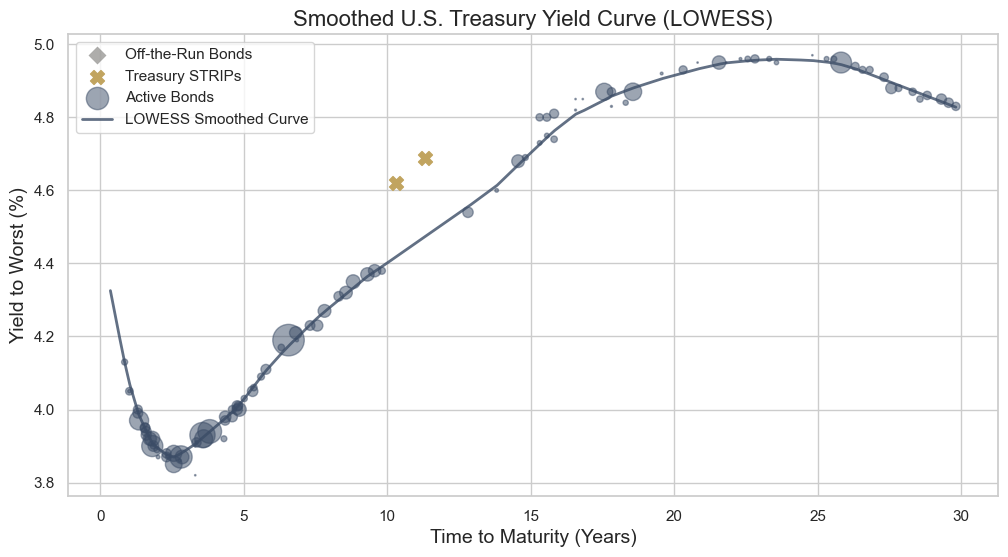

In [19]:

x_active = df_actives["Time to Maturity"]
y_active = df_actives["Yield to Worst (%)"]
size_active = df_actives["Weight (%)"] * 100

# Off-the-run bonds
plt.scatter(
    df_offtherun["Time to Maturity"],
    df_offtherun["Yield to Worst (%)"],
    marker="D",
    s=80,
    alpha=0.5,
    label="Off-the-Run Bonds",
    color=old_money_palette[4],
    edgecolor="k",
    linewidth=0.1)

# STRIPs → gold ochre
plt.scatter(
    df_strips["Time to Maturity"],
    df_strips["Yield to Worst (%)"],
    marker="X",
    s=100,
    label="Treasury STRIPs",
    color=old_money_palette[2])

# Active bonds
plt.scatter(
    x_active,
    y_active,
    s=size_active,
    alpha=0.5,
    label="Active Bonds",
    color=old_money_palette[0])

# Prepare LOWESS curve
df_lowess = pd.DataFrame({"Time": lowess_times, "Yield": lowess_yields})
df_lowess = df_lowess.drop_duplicates(subset="Time").sort_values("Time")

from scipy.interpolate import interp1d
grid_x = np.linspace(df_actives["Time to Maturity"].min(), threshold_time_to_maturity, 1000)
lowess_interp = interp1d(df_lowess["Time"], df_lowess["Yield"], kind="linear", fill_value="extrapolate")
smoothed_yields = lowess_interp(grid_x)

# LOWESS curve
plt.plot(
    grid_x,
    smoothed_yields,
    label="LOWESS Smoothed Curve",
    color=old_money_palette[0],
    alpha=0.8,
    linewidth=2)

plt.title("Smoothed U.S. Treasury Yield Curve (LOWESS)", fontsize=16)
plt.xlabel("Time to Maturity (Years)", fontsize=14)
plt.ylabel("Yield to Worst (%)", fontsize=14)
plt.legend()
plt.show()

#### Now you can query the yield for any tenor!

In [20]:
tenor = 10 # any time fraction in years!

from scipy.interpolate import interp1d

def get_yield(tenor, x_vals, y_vals):
    """
    Returns interpolated yield for a given tenor using linear interpolation
    over a LOWESS-smoothed yield curve.

    Parameters:
        tenor (float): Time to maturity in years
        x_vals (array): LOWESS time-to-maturity points
        y_vals (array): LOWESS smoothed yields (%)

    Returns:
        float: Interpolated yield in percentage (%)
    """
    interp_func = interp1d(x_vals, y_vals, kind='linear', fill_value="extrapolate")
    return float(interp_func(tenor))

yield_at_tenor = get_yield(tenor, grid_x, smoothed_yields)
print(f"Yield at {tenor} years: {yield_at_tenor:.2f}%")

Yield at 10 years: 4.40%


## 9. Bootstrapping a U.S. Treasury Yield Curve

### What Is Bootstrapping?

We build a zero-coupon yield curve by solving for spot rates that match observed bond prices. This ensures consistency and no arbitrage.

### Key Terms

- **Par Yield**: Coupon making price = 100  
- **Spot Rate**: Yield on a zero-coupon bond  
- **Discount Factor**: Present value of 1 unit at future date  
- **Semiannual Coupons**: Standard for U.S. Treasuries  

### Example: 3 Synthetic Bonds

| Maturity | Coupon | Price |
|----------|--------|-------|
| 1Y       | 2.0%   | 98.00 |
| 2Y       | 2.5%   | 97.50 |
| 3Y       | 3.0%   | 98.20 |

We solve for spot rates recursively.  
Each bond gives linear equations of the form:

$$
\text{Price} = \sum (\text{Coupon} \cdot D(t)) + \text{Principal} \cdot D(T)
$$

Where $D(t) = \frac{1}{(1 + z_t)^t}$

### Output: Bootstrapped Discount Factors

| Year | Discount Factor |
|------|-----------------|
| 0.5  | 0.9802          |
| 1.0  | 0.9606          |
| 1.5  | 0.9515          |
| 2.0  | 0.9273          |
| 2.5  | 0.9180          |
| 3.0  | 0.8911          |

### Real-World Curve (ETF Holdings)

1. Load U.S. Treasury bond data (price, coupon, maturity)
2. Drop duplicates in maturity
3. Bootstrap with QuantLib's `PiecewiseYieldCurve`
4. Evaluate curve fit using duration-weighted pricing error:

$$
\text{Error}_{\text{dw}} = \frac{\sum |\text{Model Price} - \text{Observed Price}| \cdot \text{Duration}}{\sum \text{Duration}}
$$

### Optional: Par Yield Curve

From discount factors $Z(t)$:

$$
\text{Par Yield}(T) = \frac{1 - Z(T)}{\sum Z(t_i)} \cdot m
$$


In [21]:
import QuantLib as ql
import pandas as pd
from datetime import date
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

def yield_curve_quantlib(df, eval_date):
    settlement_days = 1
    day_count = ql.ActualActual(ql.ActualActual.Bond)
    min_ttm = 0.25

    ql_eval_date = ql.Date(eval_date.day, eval_date.month, eval_date.year)
    ql.Settings.instance().evaluationDate = ql_eval_date
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)

    df_full = df.copy()
    df = df_full.dropna(subset=["Maturity", "Price", "Coupon (%)", "Par Value", "Mod. Duration", "Bond Age (Years)"]).copy()

    # Compute time to maturity (QL format)
    bond_daycount = ql.ActualActual(ql.ActualActual.Bond)
    df["QL_TTM"] = df["Maturity"].apply(
        lambda d: bond_daycount.yearFraction(ql_eval_date, ql.Date(d.day, d.month, d.year))
    )

    # Filter: bonds with positive and sufficiently long TTM
    df = df[df["QL_TTM"] > min_ttm]

    # Sort and deduplicate using rounded TTM to avoid QuantLib interpolation crashes
    df = (
        df.sort_values(by="Bond Age (Years)")
          .assign(QL_TTM_rounded=lambda d: d["QL_TTM"].round(6))
          .drop_duplicates(subset="QL_TTM_rounded", keep="first")
    )

    helpers = []
    bond_objs = []

    for _, row in df.iterrows():
        maturity = ql.Date(row["Maturity"].day, row["Maturity"].month, row["Maturity"].year)
        schedule = ql.Schedule(
            ql_eval_date, maturity, ql.Period(ql.Semiannual),
            calendar, ql.Unadjusted, ql.Unadjusted,
            ql.DateGeneration.Backward, False
        )
        bond = ql.FixedRateBond(
            settlement_days,
            float(row["Par Value"]),
            schedule,
            [float(row["Coupon (%)"]) / 100],
            day_count
        )

        try:
            helper = ql.BondHelper(ql.QuoteHandle(ql.SimpleQuote(float(row["Price"]))), bond)
            helpers.append(helper)
            bond_objs.append((row["Name"], bond, float(row["Price"]), float(row["Mod. Duration"])))
        except Exception as e:
            logger.error(f"Error creating BondHelper for bond {row['Name']} with Maturity: {row['Maturity']}: {e}")

    # Construct piecewise yield curve
    try:
        curve_obj = ql.PiecewiseLogCubicDiscount(ql_eval_date, helpers, day_count)
        curve_obj.enableExtrapolation()
    except Exception as e:
        logger.error(f"Error constructing PiecewiseLogCubicDiscount curve: {e}")
        return None, None, None, None

    curve_handle = ql.YieldTermStructureHandle(curve_obj)
    results = []
    total_error = 0
    total_duration = 0

    for name, bond, price, duration in bond_objs:
        try:
            bond.setPricingEngine(ql.DiscountingBondEngine(curve_handle))
            model_price = bond.cleanPrice()

            # Estimate YTW
            ytw = bond.bondYield(price, day_count, ql.Compounded, ql.Semiannual)
            interest_rate = ql.InterestRate(ytw, day_count, ql.Compounded, ql.Semiannual)
            
            # Model duration and convexity
            model_duration = ql.BondFunctions.duration(bond, interest_rate, ql.Duration.Modified)
            model_convexity = ql.BondFunctions.convexity(bond, interest_rate)

            error = abs(model_price - price)
            weighted_error = error * duration

            results.append({
                "Name": name,
                "Maturity": bond.maturityDate().ISO(),
                "Observed": price,
                "Model": model_price,
                "Error": round(error, 4),
                "Duration QL": duration,
                "Weighted Error": round(weighted_error, 4),
                "Model Yield": ytw,
                "Model Duration": model_duration,
                "Model Convexity": model_convexity
            })

            total_error += weighted_error
            total_duration += duration

        except Exception as e:
            logger.error(f"Error pricing bond {name}: {e}")

    df_result = pd.DataFrame(results)
    df_full["Maturity"] = pd.to_datetime(df_full["Maturity"])
    df_result["Maturity"] = pd.to_datetime(df_result["Maturity"])
    
    # Avoid duplicate merge columns
    merge_cols = [col for col in df_result.columns if col not in df_full.columns or col == "Maturity"]
    df_merged = df_full.merge(df_result[merge_cols], on="Maturity", how="left")

    dw_error = total_error / total_duration if total_duration > 0 else None

    return curve_obj, curve_handle, df_merged, dw_error

In [22]:
curve_obj, curve_handle, df_actives, dw_error = yield_curve_quantlib(df_actives, eval_date = eval_date)
df_actives = df_actives.dropna(subset=["Observed"]).copy()

### Spot Rate Curve (Zero-Coupon Curve)

Spot rates represent yields on **zero-coupon bonds** maturing at different horizons.
From discount factor $D(t)$:

- **Discrete compounding**:
  $$
  s(t) = \left( \frac{1}{D(t)} \right)^{1/t} - 1
  $$

Spot rates allow precise **present value calculations** and form the core of interest rate models.

### Forward Rate Curve

The **forward rate curve** reflects **implied future interest rates** between time intervals.

- **Discrete forward rate** from $t_1$ to $t_2$:
  $$
  f(t_1, t_2) = \left( \frac{D(t_1)}{D(t_2)} \right)^{1/(t_2 - t_1)} - 1
  $$

Used for:
- Derivatives pricing (FRAs, swaps)  
- Policy rate forecasting  
- Term premium analysis

In [23]:
# Let's extract the bonds as pillar points that we used:
pillar_dates = curve_obj.dates()
pillar_rates = [curve_obj.zeroRate(d, curve_obj.dayCounter(), ql.Compounded, ql.Annual).rate() * 100 for d in pillar_dates]

df_pillars = pd.DataFrame({
        "Date": [d.ISO() for d in pillar_dates],
        "Zero Rate (%)": pillar_rates})

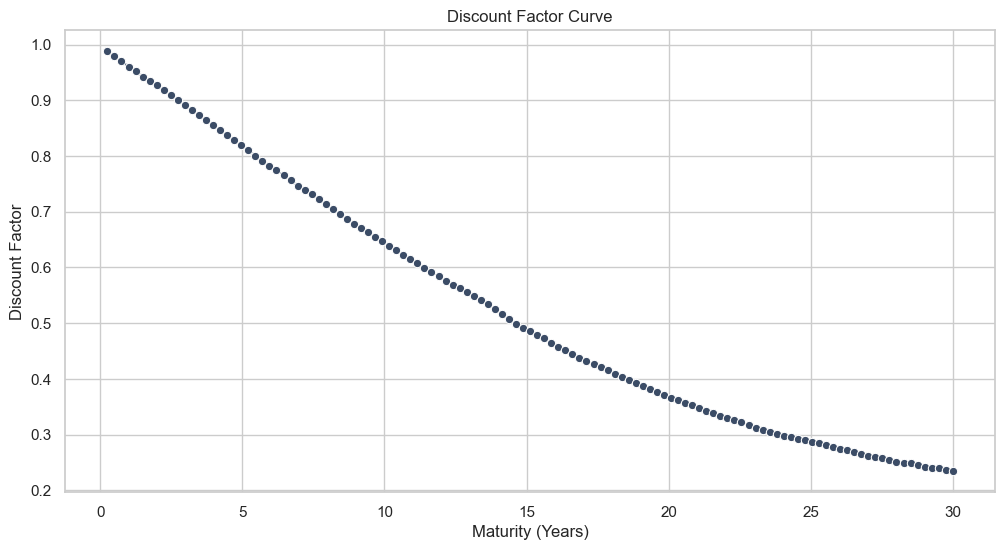

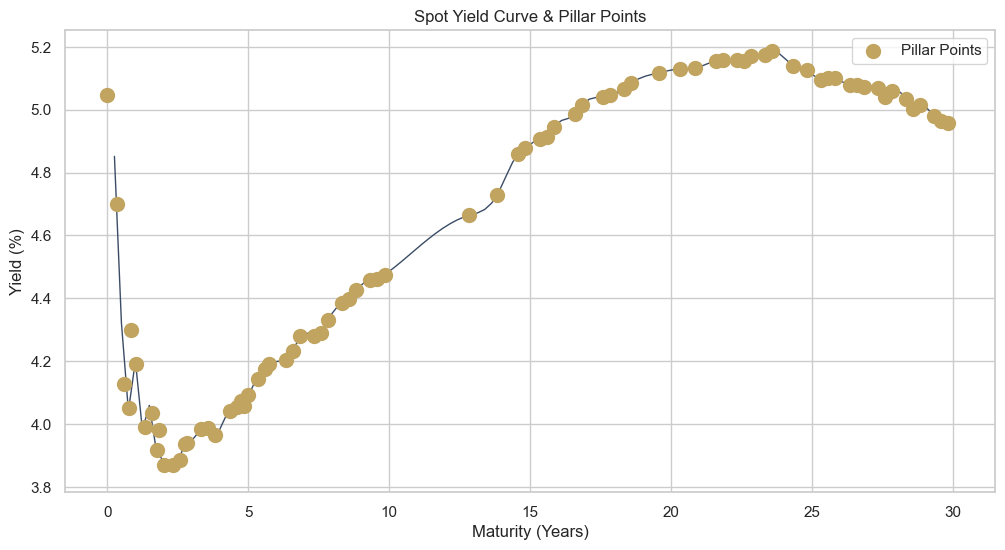

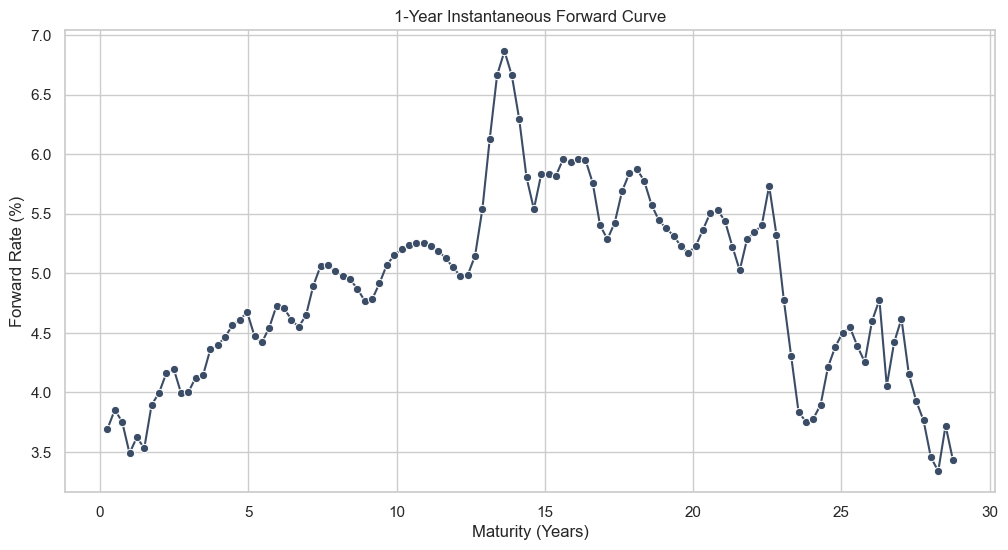

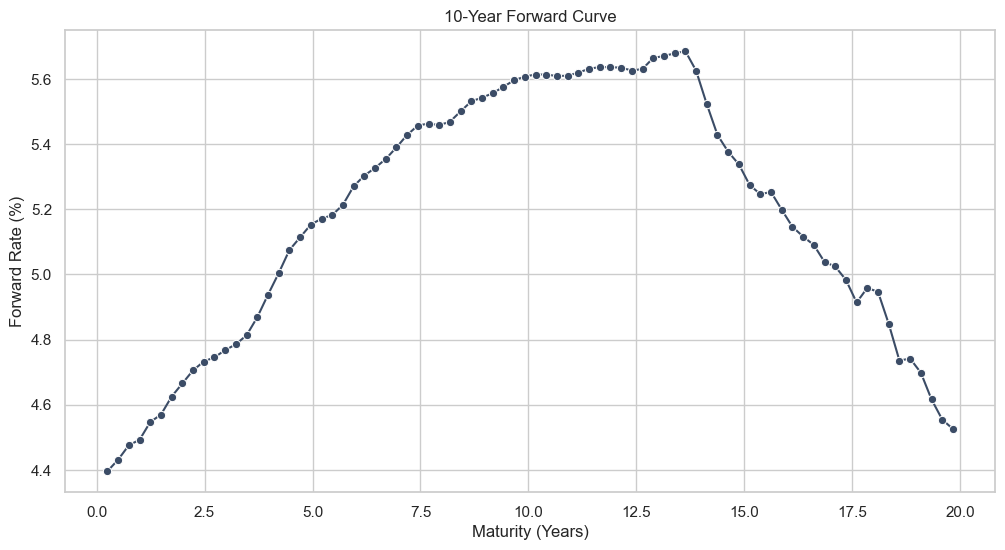

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_yield_curve_elements(curve_obj, curve_handle, eval_date=None, calculate_forward_rate=True, calculate_bond_forward_price=False):
    if eval_date is None:
        eval_date = ql.Settings.instance().evaluationDate

    times = np.linspace(0.25, 30, 121)
    compounding = ql.Compounded
    frequency = ql.Annual
    day_counter = curve_obj.dayCounter()

    # Extract yield curve elements
    discount_factors = [curve_handle.discount(t) for t in times]
    spot_rates = [curve_handle.zeroRate(t, compounding, frequency, True).rate() * 100 for t in times]
    # Initialize forward rate arrays
    forward_rates = np.full_like(times, np.nan)
    forward_10y = np.full_like(times, np.nan)

    if calculate_forward_rate:
        # 1Y forward rate calculation
        forward_rates = [
            curve_handle.forwardRate(t, t + 1, ql.Continuous, ql.Annual, True).rate() * 100
            if (t + 1 <= 30) else np.nan for t in times
        ]

        # 10Y forward rate calculation
        forward_10y = [
            curve_handle.forwardRate(t, t + 10, ql.Continuous, ql.Annual, True).rate() * 100
            if (t + 10 <= 30) else np.nan for t in times
        ]

    df_curve = pd.DataFrame({
        "Time (Years)": times,
        "Discount Factor": discount_factors,
        "Spot Rate (%)": spot_rates,
        "1Y Forward Rate (%)": forward_rates,
        "10Y Forward Rate (%)": forward_10y
    })
    # pillar dates from the original curve object
    df_pillars = pd.DataFrame()

    try:
        if hasattr(curve_obj, "dates"):
            pillar_dates = curve_obj.dates()
            pillar_times = [curve_obj.timeFromReference(d) for d in pillar_dates]
            pillar_rates = [
                curve_obj.zeroRate(d, day_counter, compounding, frequency).rate() * 100
                for d in pillar_dates
            ]
            df_pillars = pd.DataFrame({
                "Time (Years)": pillar_times,
                "Zero Rate (%)": pillar_rates
            })
    except Exception as e:
        print(f"Could not extract pillar points: {e}")
    # — 1) Discount Factor Curve —
    fig1, ax1 = plt.subplots()
    sns.lineplot(
        data=df_curve,
        x="Time (Years)",
        y="Discount Factor",
        marker="o",
        color=old_money_palette[0],
        ax=ax1
    )
    ax1.set_title("Discount Factor Curve")
    ax1.set_xlabel("Maturity (Years)")
    ax1.set_ylabel("Discount Factor")
    ax1.grid(True)

    # 2) Spot Yield Curve with Pillar Points —
    fig2, ax2 = plt.subplots()
    sns.lineplot(
        data=df_curve,
        x="Time (Years)",
        y="Spot Rate (%)",
        linewidth=1,
        color=old_money_palette[0],
        ax=ax2
    )
    if not df_pillars.empty:
        ax2.scatter(
            df_pillars["Time (Years)"],
            df_pillars["Zero Rate (%)"],
            s=100,
            marker="o",
            label="Pillar Points",
            color=old_money_palette[2],
            zorder=5
        )
    ax2.set_title("Spot Yield Curve & Pillar Points")
    ax2.set_xlabel("Maturity (Years)")
    ax2.set_ylabel("Yield (%)")
    ax2.legend()
    ax2.grid(True)

    # 3) 1-Year Instantaneous Forward Curve —
    fig3, ax3 = plt.subplots()
    sns.lineplot(
        data=df_curve,
        x="Time (Years)",
        y="1Y Forward Rate (%)",
        marker="o",
        color=old_money_palette[0],
        ax=ax3
    )
    ax3.set_title("1-Year Instantaneous Forward Curve")
    ax3.set_xlabel("Maturity (Years)")
    ax3.set_ylabel("Forward Rate (%)")
    ax3.grid(True)

    # 4) 10-Year Forward Curve —
    fig4, ax4 = plt.subplots()
    sns.lineplot(
        data=df_curve,
        x="Time (Years)",
        y="10Y Forward Rate (%)",
        color=old_money_palette[0],
        marker="o",
        ax=ax4
    )
    ax4.set_title("10-Year Forward Curve")
    ax4.set_xlabel("Maturity (Years)")
    ax4.set_ylabel("Forward Rate (%)")

    return

plot_yield_curve_elements(curve_obj, curve_handle, eval_date=eval_date, calculate_forward_rate=True, calculate_bond_forward_price=False)


## 10. Rich/Cheap Analysis of Government Bonds Relative to a Model Curve

Rich/cheap analysis is a method to identify relative value opportunities by comparing the observed market price of a government bond to its model-implied fair value. In a government bond universe, we assume homogeneity in credit quality and liquidity, which simplifies interpretation and focuses the analysis on pricing efficiency along the yield curve.

#### Conceptual Framework: Price Deviation from Model

Instead of comparing yields to a par curve (which may be distorted by coupon effects), this implementation focuses on price-based deviations from a curve-implied value. The pricing error is computed as:

$$
\text{Error}_i = \frac{P^{\text{model}}_i - P^{\text{market}}_i}{P^{\text{market}}_i}
$$

- If $\text{Error}_i > 0$: the bond is **cheap** (market undervalues it relative to model)
- If $\text{Error}_i < 0$: the bond is **rich** (market overvalues it)

This approach relies on a term structure model (e.g., spline, Nelson-Siegel, or bootstrapped curve) that prices bonds based on observed zero-coupon yields or spot rates.

#### Visual Diagnostics

The following plots provide insight into systematic model biases or structural inefficiencies:

- Market Price vs. Model Price
- Error vs. Coupon
- Error vs. Maturity
- Error vs. Bond Age
- Yield Delta 

These visualizations help identify patterns such as:

- Long-dated or high-coupon bonds being persistently over- or under-valued
- Aging effects from off-the-run status
- Model misspecification in specific regions of the curve


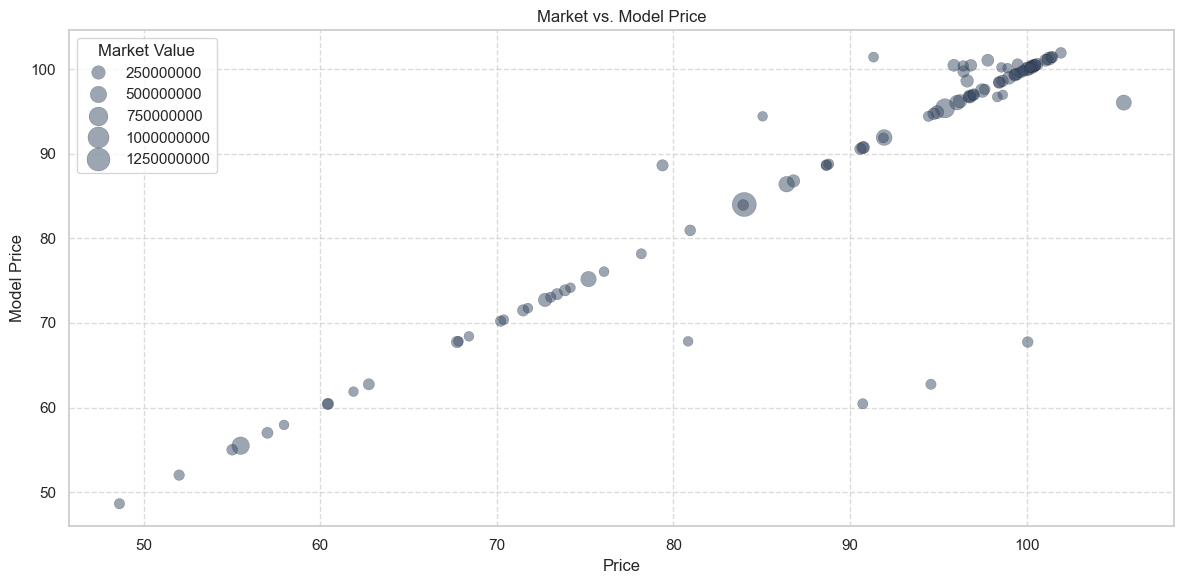

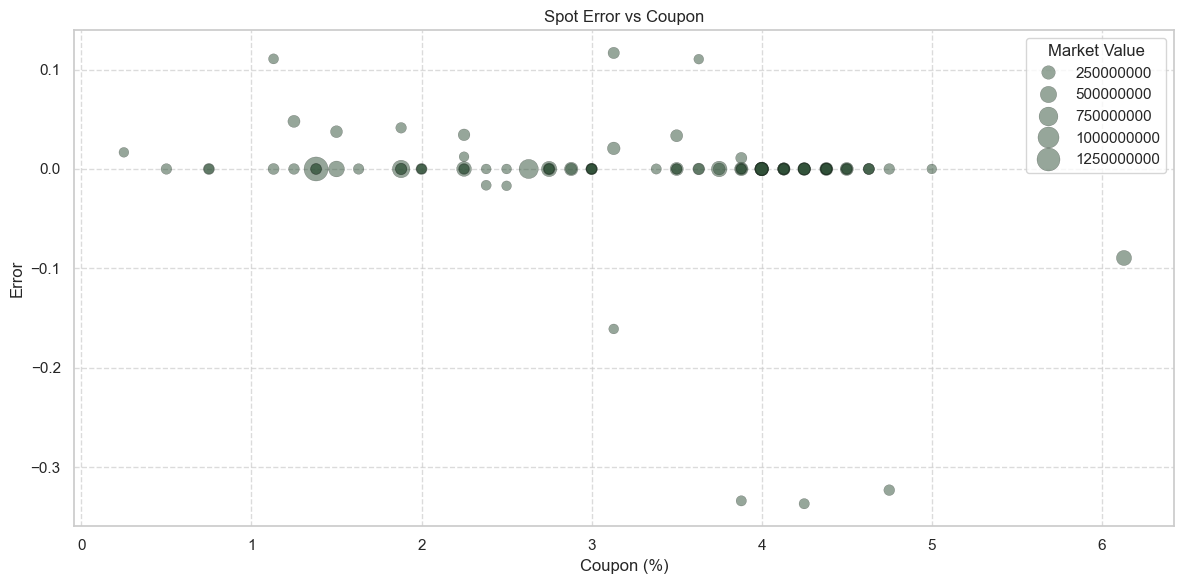

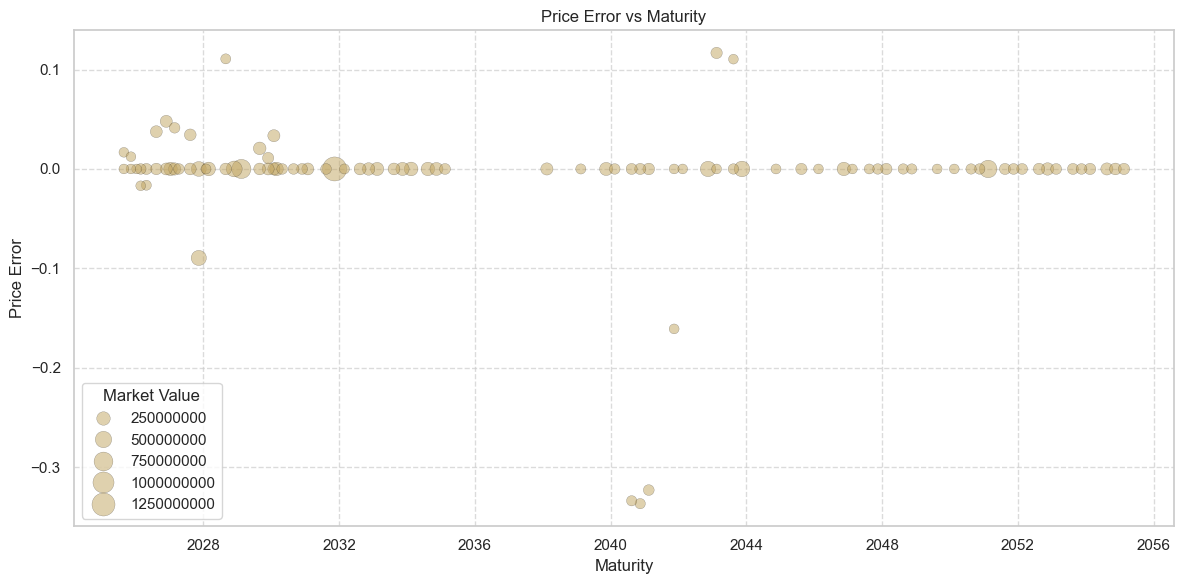

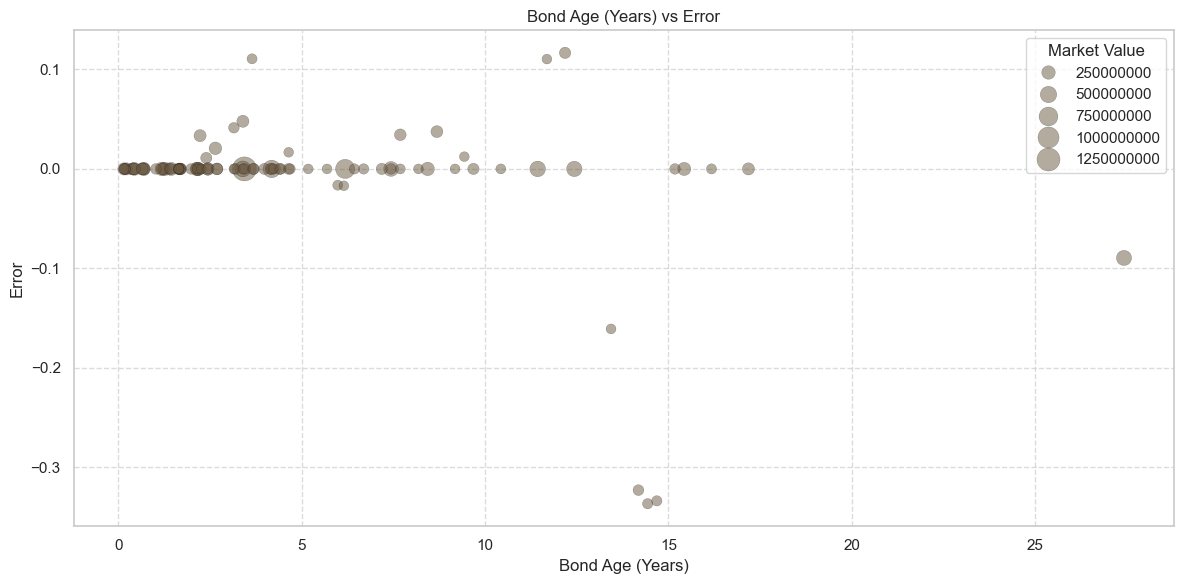

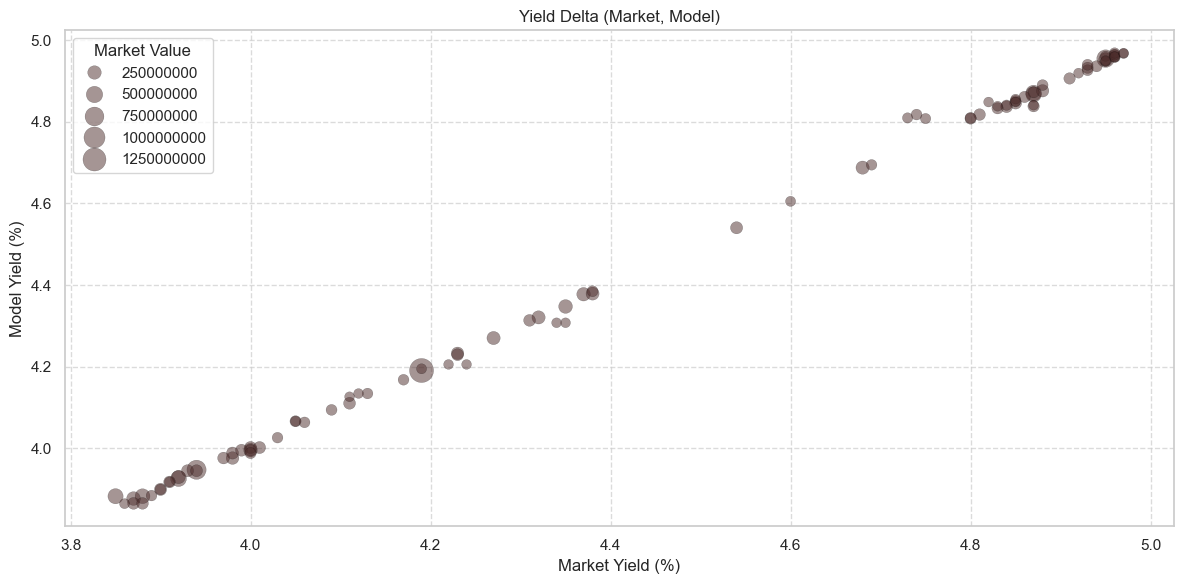

In [25]:
# Clean the data
df_actives_clean = df_actives.dropna(
    subset=["Price", "Model", "Market Value", "Coupon (%)", "Error", "Maturity", "Bond Age (Years)"]).copy()

# Calculate error as percentage
df_actives_clean["Error"] = (
    (df_actives_clean["Model"] - df_actives_clean["Price"]) / df_actives_clean["Price"])

# Drop rows where 'Model Yield' or 'YTM (%)' is missing
df_actives_clean = df_actives_clean.dropna(subset=["Model Yield", "YTM (%)"])
# Compute the yield difference
df_actives_clean["Yield Delta"] = df_actives_clean["YTM (%)"] - (df_actives_clean["Model Yield"] * 100)

# General plot function for scatter plots
def scatter_plot(x, y, data, size_column=None, title="", xlabel="", ylabel="", legend=False, grid=True, color=None):
    plt.figure()
    sns.scatterplot(
        x=x, y=y, data=data,
        size=size_column, sizes=(50, 300),
        alpha=0.5, color=color if color else old_money_palette[0],
        edgecolor="black", linewidth=0.2
    )
    if legend:
        plt.legend(title="Size", loc="upper right")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if grid:
        plt.grid(True, which="both", linestyle="--", linewidth=1, alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot 1: Model vs Market Price
scatter_plot(
    "Price", "Model", data=df_actives_clean,
    size_column="Market Value", title="Market vs. Model Price",
    xlabel="Price", ylabel="Model Price", color=old_money_palette[0]
)

# Plot 2: Spot Error vs Coupon
scatter_plot(
    x="Coupon (%)", y="Error", data=df_actives_clean,
    size_column="Market Value", title="Spot Error vs Coupon",
    xlabel="Coupon (%)", ylabel="Error", color=old_money_palette[1]
)

# Plot 3: Price Error vs Maturity
scatter_plot(
    x="Maturity", y="Error", data=df_actives_clean,
    size_column="Market Value", title="Price Error vs Maturity",
    xlabel="Maturity", ylabel="Price Error", color=old_money_palette[2]
)

# Plot 4: Bond Age vs Price Error
scatter_plot(
    x="Bond Age (Years)", y="Error", data=df_actives_clean,
    size_column="Market Value", title="Bond Age (Years) vs Error",
    xlabel="Bond Age (Years)", ylabel="Error", color=old_money_palette[8]
)

# Plot 5:Yield Delta Error vs Time to Maturity
scatter_plot(
    x="YTM (%)", y=df_actives_clean["Model Yield"] * 100, data=df_actives_clean,
    size_column="Market Value", title="Yield Delta (Market, Model)",
    xlabel="Market Yield (%)", ylabel="Model Yield (%)", color=old_money_palette[5]
)

#### Screening Long/Short Candidates

#### Duration-Normalized Signal: The "Rich Cheap Score"

To account for differences in interest rate sensitivity, we normalize the **yield difference** (rather than price error) by the bond’s duration:

$$
\text{RichCheap Score}_i = \frac{\Delta y_i}{\text{Duration}_i}
$$

where:

- $\Delta y_i = y^{\text{market}}_i - y^{\text{model}}_i$ is the **Yield Delta**
- $\text{Duration}_i$ is the bond’s interest rate sensitivity

This is analogous to a DV01-normalized measure of relative value. It expresses mispricing per unit of risk and allows fair comparisons across the maturity spectrum.

To identify trade ideas, the RichCheap Score is filtered using a symmetric threshold:

- Bonds with $\text{RichCheap Score} > \tau$ are **long candidates** (cheap)
- Bonds with $\text{RichCheap Score} < -\tau$ are **short candidates** (rich)

These candidates can be plotted by time to maturity to visualize the shape and clustering of mispricings across the curve.

The signals are interpreted as follows:

- **Long**: The market yield is higher than the model-implied yield, indicating the bond is **undervalued** for its risk profile
- **Short**: The market yield is lower than the model-implied yield, indicating the bond is **overvalued** relative to the curve

#### Interpretation in the Government Bond Context

In a universe restricted to sovereign issuers (e.g., U.S. Treasuries), the following assumptions simplify the analysis:

- **Credit quality** is uniform
- **Liquidity** differences are limited but may still exist (e.g., on-the-run vs. off-the-run)
- **Tax treatments** are similar across the curve

Mispricings can therefore be attributed more cleanly to:

- Market technicals (supply/demand imbalances)
- Curve structure anomalies
- Benchmark status or index inclusion effects
- Rolling and carry distortions

#### Potential Enhancements

To deepen the analysis, consider the following extensions:

- Filter out illiquid or stale-priced bonds
- Incorporate bid/ask spreads or quoted liquidity metrics
- Track signal stability over time to identify persistent vs. transient anomalies
- Run historical backtests to evaluate performance of long/short baskets

| Concept              | Definition                                                    |
|----------------------|----------------------------------------------------------------|
| Rich                 | Market yield < Model yield (overvalued)                        |
| Cheap                | Market yield > Model yield (undervalued)                      |
| Yield Delta          | $y^{\text{market}} - y^{\text{model}}$                        |
| RichCheap Score      | Yield Delta normalized by duration                             |

This method provides a quantitative, risk-adjusted view of pricing anomalies along a sovereign yield curve. By focusing on **yield-based deviations** and normalizing for duration, it offers a robust framework to inform trading decisions and support model validation.


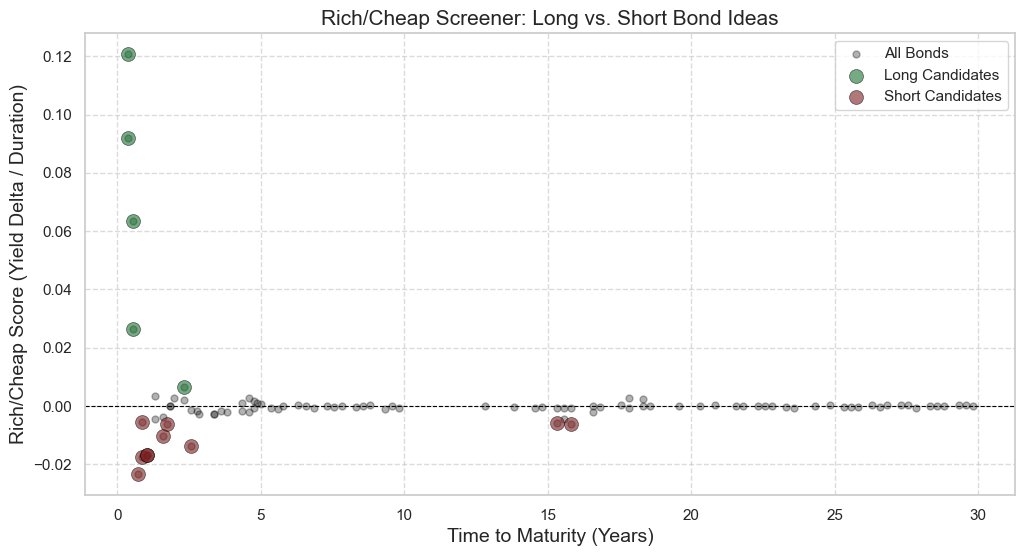

In [26]:
import matplotlib.pyplot as plt

# Set signal threshold (e.g., 0.5% absolute yield difference scaled by duration)
error_threshold = 0.005

# Drop incomplete rows if needed
df_actives_clean = df_actives_clean.dropna(subset=["YTM (%)", "Model Yield", "Duration QL", "Time to Maturity"]).copy()

# Compute and round yield delta (in basis points)
df_actives_clean["Yield Delta"] = df_actives_clean["YTM (%)"] - (df_actives_clean["Model Yield"] * 100)
df_actives_clean["Yield Delta"] = df_actives_clean["Yield Delta"].round(5)

# Compute Rich/Cheap Score
df_actives_clean["RichCheap Score"] = df_actives_clean["Yield Delta"] / df_actives_clean["Duration QL"]

# Identify long and short candidates
long_candidates = df_actives_clean[df_actives_clean["RichCheap Score"] > error_threshold].copy()
short_candidates = df_actives_clean[df_actives_clean["RichCheap Score"] < -error_threshold].copy()

# Sort and select top 10
long_candidates = long_candidates.sort_values(by="RichCheap Score", ascending=False).head(10)
short_candidates = short_candidates.sort_values(by="RichCheap Score").head(10)

# All bonds (light gray)
plt.scatter(df_actives_clean["Time to Maturity"], df_actives_clean["RichCheap Score"],
            alpha=0.3, s=25, color="black", label="All Bonds")

# Long candidates (cheap)
plt.scatter(long_candidates["Time to Maturity"], long_candidates["RichCheap Score"], alpha=0.6,
            s=100, color="#1A7431", edgecolor="black", linewidth=0.5, label="Long Candidates")

# Short candidates (rich)
plt.scatter(short_candidates["Time to Maturity"], short_candidates["RichCheap Score"], alpha=0.6,
            s=100, color="#7C1E1E", edgecolor="black", linewidth=0.5, label="Short Candidates")

# Reference line
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)

# Labels and formatting
plt.xlabel("Time to Maturity (Years)", fontsize=14)
plt.ylabel("Rich/Cheap Score (Yield Delta / Duration)", fontsize=14)
plt.title("Rich/Cheap Screener: Long vs. Short Bond Ideas", fontsize=15)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

### Rich/Cheap in Treasuries Is Typically Very Subtle
You're analyzing U.S. Treasuries, a highly liquid and efficient market. In this market:

Pricing discrepancies are often within a few basis points and tend to disappear quickly.
Significant rich/cheap deviations usually arise from:

- Special collateral demand (e.g. on-the-run bonds)

- Auction distortions

- STRIP vs. coupon dislocations

The top signals on the very short end (<1Y) may reflect market microstructure, not true arbitrage opportunities.



### Out of Sample Bonds

To ensure the robustness of our relative value analysis, we assess bonds **not used in the initial curve calibration**. These *out-of-sample* bonds were excluded from the QuantLib yield curve construction and thus serve as a cleaner test of model performance.

By processing them against the **existing QuantLib curve**, we can:

- Estimate **model-implied prices and yields**
- Compute **duration- and convexity-adjusted risk measures**
- Calculate a **RichCheap Score** based on **yield deltas**, normalized by duration

In [27]:
# Let's retrieve the out-of-sample bonds (unfortunately, we don't have identifiers like CUSIP or ISIN)
# Define a composite key to identify each bond
key_cols = ["Maturity", "Coupon (%)", "Par Value"]

df_full_keyed = df_full.copy()
df_actives_clean_keyed = df_actives_clean.copy()

for col in ["Coupon (%)", "Par Value"]:
    df_full_keyed[col] = df_full_keyed[col].round(4)
    df_actives_clean_keyed[col] = df_actives_clean_keyed[col].round(4)

# Create helper keys
df_full_keyed["bond_key"] = df_full_keyed[key_cols].astype(str).agg("_".join, axis=1)
df_actives_clean_keyed["bond_key"] = df_actives_clean_keyed[key_cols].astype(str).agg("_".join, axis=1)

# Carve out out-of-sample bonds
used_keys = set(df_actives_clean_keyed["bond_key"])
df_out_of_sample = df_full_keyed[~df_full_keyed["bond_key"].isin(used_keys)].copy()

# Drop helper column if desired
df_out_of_sample.drop(columns=["bond_key"], inplace=True)

In [28]:
# Let's build a function to evaluate out-of-sample bonds

# General setup
settlement_days = 1
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
day_count = ql.ActualActual(ql.ActualActual.Bond)
compounding = ql.Compounded
frequency = ql.Semiannual

def evaluate_out_of_sample_bonds(df, curve_handle, ql_eval_date, settlement_days=1,
                                  day_count=ql.ActualActual(ql.ActualActual.Bond),
                                  compounding=ql.Compounded, frequency=ql.Semiannual,
                                  calendar=ql.UnitedStates(ql.UnitedStates.GovernmentBond)):

    results = []

    for _, row in df.iterrows():
        try:
            # Build schedule
            maturity = ql.Date(row["Maturity"].day, row["Maturity"].month, row["Maturity"].year)
            schedule = ql.Schedule(
                ql_eval_date, maturity, ql.Period(frequency),
                calendar, ql.Unadjusted, ql.Unadjusted,
                ql.DateGeneration.Backward, False
            )

            # Create QuantLib bond
            bond = ql.FixedRateBond(
                settlement_days,
                float(row["Par Value"]),
                schedule,
                [float(row["Coupon (%)"]) / 100],
                day_count
            )

            # Attach pricing engine
            bond.setPricingEngine(ql.DiscountingBondEngine(curve_handle))

            # Compute model price
            model_price = bond.cleanPrice()

            # Model yield
            model_yield = bond.bondYield(
                model_price, day_count, compounding, frequency
            )

            # Duration and convexity
            mod_duration = ql.BondFunctions.duration(
                bond, model_yield, day_count, compounding, frequency, ql.Duration.Modified
            )
            convexity = ql.BondFunctions.convexity(
                bond, model_yield, day_count, compounding, frequency
            )

            # Error (price deviation)
            yield_delta = ((model_yield * 100) - row["YTM (%)"])
            richcheap_score = yield_delta / mod_duration if mod_duration != 0 else None

            results.append({
                "Name": row.get("Name", None),
                "Maturity": row["Maturity"],
                "Price": row["Price"],
                "Model": model_price,
                "Model Yield": model_yield,
                "Model Duration": mod_duration,
                "Model Convexity": convexity,
                "Yield Delta": yield_delta,
                "Error": row["Price"] - model_price,
                "RichCheap Score": richcheap_score
            })

        except Exception as e:
            print(f"Failed for bond with maturity {row['Maturity']}: {e}")

    return pd.DataFrame(results)

# Evaluate the bonds
ql_eval_date = ql.Date(eval_date.day, eval_date.month, eval_date.year)
ql.Settings.instance().evaluationDate = ql_eval_date
out_of_sample_results_df = evaluate_out_of_sample_bonds(df_out_of_sample, curve_handle, ql_eval_date)

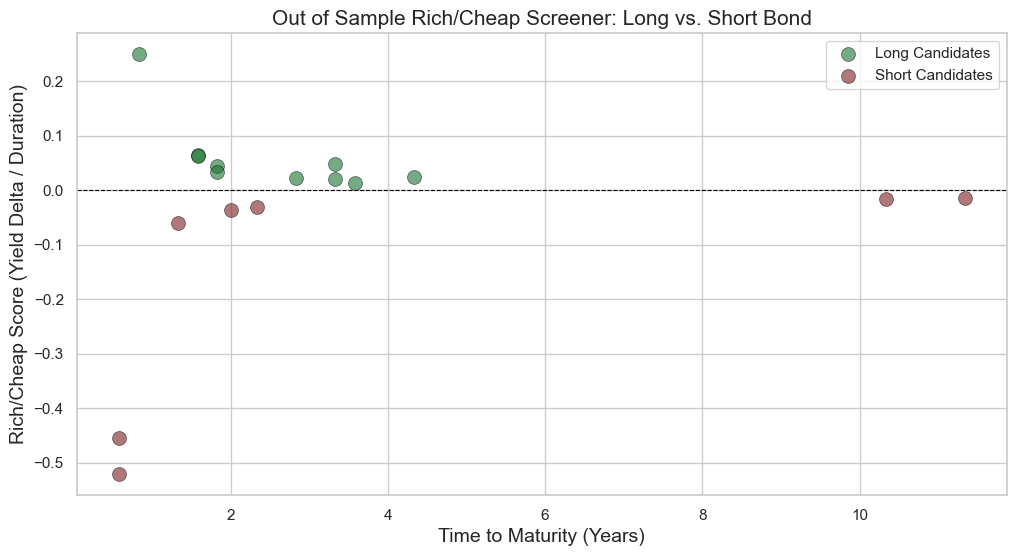

In [29]:
df_screened = out_of_sample_results_df.copy()
df_screened["Maturity"] = pd.to_datetime(df_screened["Maturity"])
day_count = ql.ActualActual(ql.ActualActual.Bond)

df_screened["Maturity"] = pd.to_datetime(df_screened["Maturity"])

df_screened["Time to Maturity"] = df_screened["Maturity"].apply(
    lambda d: day_count.yearFraction(ql_eval_date, ql.Date(d.day, d.month, d.year)))

# LONG when RichCheap Score is positive and above threshold
long_candidates_screened = df_screened[df_screened["RichCheap Score"] > error_threshold].copy()
long_candidates_screened = long_candidates_screened.sort_values(by="RichCheap Score", ascending=False).head(10)

# SHORT when RichCheap Score is negative and below threshold
short_candidates_screened = df_screened[df_screened["RichCheap Score"] < -error_threshold].copy()
short_candidates_screened = short_candidates_screened.sort_values(by="RichCheap Score").head(10)

# Long candidates (cheap)
plt.scatter(long_candidates_screened["Time to Maturity"], long_candidates_screened["RichCheap Score"], alpha=0.6,
            s=100, color="#1A7431", edgecolor="black", linewidth=0.5, label="Long Candidates")

# Short candidates (rich)
plt.scatter(short_candidates_screened["Time to Maturity"], short_candidates_screened["RichCheap Score"], alpha=0.6,
            s=100, color="#7C1E1E", edgecolor="black", linewidth=0.5, label="Short Candidates")

# Add horizontal reference line
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)

# Labels and layout
plt.xlabel("Time to Maturity (Years)", fontsize=14)
plt.ylabel("Rich/Cheap Score (Yield Delta / Duration)", fontsize=14)
plt.title("Out of Sample Rich/Cheap Screener: Long vs. Short Bond", fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

###  10. Yield Curve Comparison: Observed vs. Bootstrapped vs. Fed

In this section, we compare and interpret three yield curves:

- Observed market yields (YTW)  
- Bootstrapped spot rates from QuantLib  
- The Fed's par yield curve (SVENPYXX)


#### Curve Definitions

| Curve Type                     | Source                        | Method                         | Interpretation                          |
|-------------------------------|-------------------------------|---------------------------------|------------------------------------------|
| **Observed Yield Curve (YTW)** | Market Quotes (ETF Holdings)  | Empirical, non-arbitrage       | What the market “pays” for specific bonds |
| **LOWESS-smoothed YTW**        | Smoothed observed YTW         | Local polynomial fit            | Trend estimate of noisy observations     |
| **Bootstrapped Spot Curve**    | From bond prices via QuantLib | No-arbitrage spot curve         | Fundamental curve for discounting        |
| **Fed Par Curve (SVENPYXX)**   | Estimated by Fed              | Svensson model (par yields)     | Policy benchmark for risk-free rates     |


####  Why the curves differ

**1. LOWESS YTW is often lower than the bootstrapped curve:**
- Most ETF holdings are **premium bonds** (above par).
- Their **YTW underestimates** the average forward rate implied by cash flows.
- LOWESS just smooths YTW — it **doesn't ensure no-arbitrage**.

**2. The bootstrapped curve reflects:**
- A **full term structure** (zero-coupon rates),
- **Actual bond prices**, consistent with **no-arbitrage**,
- Possibly **liquidity or credit premia** embedded in the prices.

**3. The Fed par curve is often smoother and lower:**
- Based on a **Svensson model fit** to Treasury data,
- Reflects **theoretical par bonds**, not actual traded instruments,
- May omit liquidity premiums found in real market pricing.

#### Is it consistent that Bootstrapped > Fed Par Curve?

Yes. Consider the upward-sloping yield curve environment:

- Par yield **averages** future spot rates.
- Spot rate reflects **only the final discount point**.

So the bootstrapped curve should lie **above** the par curve — particularly in rising rate environments.

#### Practical Applications

| Use Case                          | Best Curve to Use                |
|----------------------------------|----------------------------------|
| Bond relative value analysis     | **YTW vs Par Yield**             |
| Risk-neutral pricing of cash flows | **Bootstrapped Spot Curve**      |
| Portfolio valuation              | **Discount curve (bootstrapped)**|
| Policy benchmarking              | **Fed Par Curve (SVENPYXX)**     |
| Forecasting expectations         | **Forward Rates (from bootstrapped)** |

#### Summary

- The observed YTW curve is **useful for market diagnostics** but contains noise and pricing distortions.
- The QuantLib bootstrapped curve is **internally consistent and arbitrage-free** and can be used for valuation and risk analysis.
- The Fed's par curve provides a **policy-aligned benchmark** — smooth, interpretable, but disconnected from daily market prices.

Even though your bootstrapped curve is slightly **above** the Fed par curve, that is **fully consistent** with the structure and purpose of each curve.

In [30]:
import pandas as pd

file_path = f'{PATH_TO_CSV_FILES}feds200628.csv'

# Step 1: Find the correct header row
with open(file_path, "r") as f:
    lines = f.readlines()

header_row_index = None
for i, line in enumerate(lines[:50]):
    if "Date" in line:
        header_row_index = i
        break

# Step 2: Load the data from that row
df_fed_raw = pd.read_csv(file_path, skiprows=header_row_index)
df_fed_raw.columns = df_fed_raw.columns.str.strip()

# Step 3: Clean and extract
df_fed_raw["Date"] = pd.to_datetime(df_fed_raw["Date"], errors="coerce")

target_date = pd.Timestamp("2025-04-23")
df_fed = df_fed_raw[df_fed_raw["Date"] == target_date].copy()

par_cols = [col for col in df_fed.columns if col.startswith("SVENPY")]
par_cols.sort()
tenors = [int(col[-2:]) for col in par_cols]
svenpy = df_fed[par_cols].values.flatten().tolist()

print(f"Loaded SVENPY par yields for {target_date.date()}")
print("Tenors:", tenors)
print("Yields:", svenpy)

Loaded SVENPY par yields for 2025-04-23
Tenors: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Yields: [4.057, 3.8926, 3.8848, 3.9424, 4.0258, 4.1172, 4.208, 4.2942, 4.3741, 4.4469, 4.5125, 4.5711, 4.6232, 4.6691, 4.7093, 4.7444, 4.7748, 4.8009, 4.8231, 4.842, 4.8577, 4.8707, 4.8813, 4.8896, 4.8961, 4.9008, 4.904, 4.9059, 4.9066, 4.9063]


#### Extract the Par Yield Curve from Quantlib

In [31]:
import QuantLib as ql
import pandas as pd

import QuantLib as ql
import pandas as pd
from scipy.optimize import brentq

def compute_par_yields(curve_handle, tenors):
    par_yields = []
    settlement_days = 1
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    frequency = ql.Semiannual
    day_count = ql.ActualActual(ql.ActualActual.Bond)
    compounding = ql.Compounded

    for tenor in tenors:
        # Generate maturity date
        maturity_date = ql.Settings.instance().evaluationDate + int(tenor * 365.25)
        schedule = ql.Schedule(
            ql.Settings.instance().evaluationDate,
            maturity_date,
            ql.Period(frequency),
            calendar,
            ql.Unadjusted, ql.Unadjusted,
            ql.DateGeneration.Backward, False
        )

        def bond_price(coupon_rate):
            bond = ql.FixedRateBond(
                settlement_days,
                100.0,
                schedule,
                [coupon_rate],
                day_count
            )
            bond.setPricingEngine(ql.DiscountingBondEngine(curve_handle))
            return bond.cleanPrice()

        # Solve: price = 100 for the right coupon
        try:
            par_coupon = brentq(lambda c: bond_price(c) - 100, 0.0001, 0.15)
            par_yields.append(par_coupon * 100)
        except Exception:
            par_yields.append(None)

    return pd.DataFrame({
        "Tenor": tenors,
        "Par Yield (%)": par_yields
    })

# Example usage:
tenors = [0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30]
par_yield_df = compute_par_yields(curve_handle, tenors)


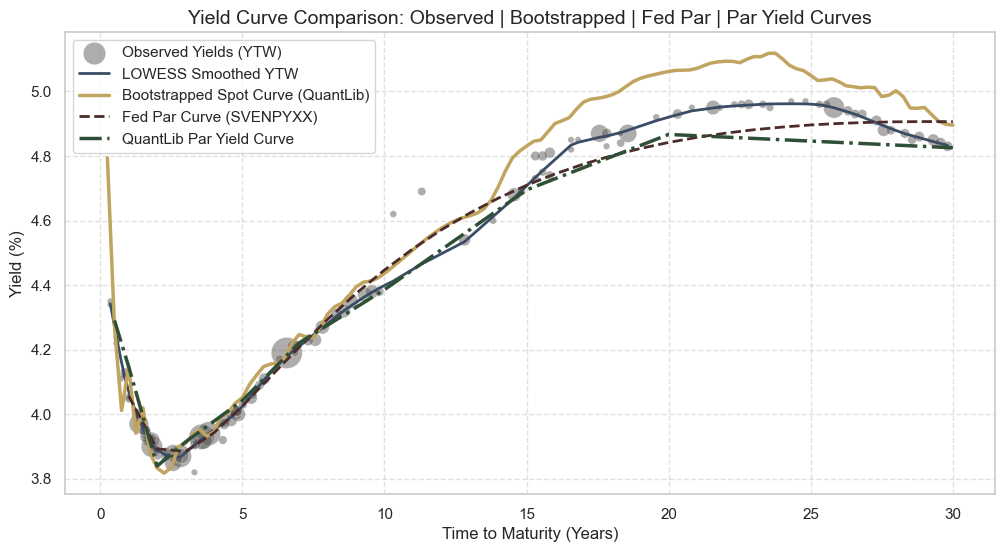

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

# --- Step 1: Observed Yield Curve from ETF data ---
df_yield_curve = df_full.dropna(subset=["Yield to Worst (%)", "Time to Maturity", "Weight (%)"]).copy()
df_yield_curve["Bubble Size"] = df_yield_curve["Weight (%)"] * 100

# LOWESS smoothing
x_obs = df_yield_curve["Time to Maturity"].values
y_obs = df_yield_curve["Yield to Worst (%)"].values
lowess_result = lowess(y_obs, x_obs, frac=0.1, return_sorted=True)

# --- Step 2: QuantLib Bootstrapped Spot Curve ---
spot_times = np.linspace(0.25, 30, 120)
spot_rates = [
    curve_handle.zeroRate(t, ql.Compounded, ql.Semiannual, True).rate() * 100
    for t in spot_times
]

# --- Step 3: Load Fed SVENPYXX Par Yield Curve ---
fed_file_path = f'{PATH_TO_CSV_FILES}feds200628.csv'

# Detect header line
with open(fed_file_path, "r") as f:
    lines = f.readlines()

header_row_index = None
for i, line in enumerate(lines[:50]):
    if "Date" in line:
        header_row_index = i
        break

# Load Fed data
df_fed_raw = pd.read_csv(fed_file_path, skiprows=header_row_index)
df_fed_raw.columns = df_fed_raw.columns.str.strip()
df_fed_raw["Date"] = pd.to_datetime(df_fed_raw["Date"], errors="coerce")

# Filter for target date
target_date = eval_date
df_fed = df_fed_raw[df_fed_raw["Date"] == target_date].copy()

# Extract par yield columns (SVENPYXX)
par_cols = [col for col in df_fed.columns if col.startswith("SVENPY")]
par_cols.sort()
tenors = [int(col[-2:]) for col in par_cols]
svenpy = df_fed[par_cols].values.flatten().tolist()

# A. Observed YTWs (scatter)
sns.scatterplot(
    data=df_yield_curve,
    x="Time to Maturity",
    y="Yield to Worst (%)",
    size="Bubble Size",
    sizes=(20, 500),
    legend=False,
    alpha=0.5,
    color=old_money_palette[4],  # Oxide Grey
    label="Observed Yields (YTW)"
)

# B. LOWESS Smoothed Observed YTW
plt.plot(
    lowess_result[:, 0],
    lowess_result[:, 1],
    color=old_money_palette[0],  # Navy
    linewidth=2,
    label="LOWESS Smoothed YTW"
)

# C. QuantLib Spot Curve
plt.plot(
    spot_times,
    spot_rates,
    color=old_money_palette[2],  # Gold Ochre
    linewidth=2.5,
    label="Bootstrapped Spot Curve (QuantLib)"
)

# D. Fed SVENPYXX Par Curve
plt.plot(
    list(range(1, 31)),
    svenpy,
    linestyle="--",
    linewidth=2,
    color=old_money_palette[5],  # Deep Burgundy
    label="Fed Par Curve (SVENPYXX)"
)

# E. QuantLib Par Yield Curve
plt.plot(
    par_yield_df["Tenor"],
    par_yield_df["Par Yield (%)"],
    linestyle="-.",
    linewidth=2.5,
    color=old_money_palette[1],  # Forest Green
    label="QuantLib Par Yield Curve"
)

# Plot
plt.title("Yield Curve Comparison: Observed | Bootstrapped | Fed Par | Par Yield Curves", fontsize=14)
plt.xlabel("Time to Maturity (Years)", fontsize=12)
plt.ylabel("Yield (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

## BONUS: QuantLib Applications in Fixed Income Analytics

QuantLib is a powerful open-source library used for modeling and analyzing fixed income securities. Below are two practical applications that demonstrate how QuantLib can be used to extract insights from bond ETF holdings and yield curves.

#### Price a When Issued Treasury Bond

We can use the discount curve to price a when issued Treasury bond. We just have to extract the correct tenor points and discount the cash flows.

#### Bond Cash Flow Aggregation from ETF Holdings

Using bond metadata from a U.S. Treasury Bond ETF, we construct cash flow schedules with QuantLib and aggregate the resulting payments by calendar quarter. This allows us to analyze when coupon payments and principal repayments are due. By summing all future cash flows within a given time horizon (e.g., 5 years), we can estimate the proportion of debt that needs to be refinanced in that period.

This method provides practical insights into the refinancing schedule and rollover risk embedded in the U.S. Treasury market, using data directly from ETF holdings.

#### Yield Curve Interpretation and Term Premiums

With QuantLib, we can extract spot rates from a constructed yield curve and interpret their shape. By comparing short-term and long-term rates, we can compute the term premium — a key metric for understanding market expectations.
A positive term premium typically indicates a normal or steep curve (reflecting higher long-term yields due to inflation or growth expectations), whereas a negative term premium suggests an inverted yield curve, often associated with recession risk.

#### Learning Takeaways

- Use QuantLib to construct and aggregate bond cash flows over time.
- Visualize debt maturity and refinancing needs using real ETF data.
- Interpret term structure of interest rates to assess market sentiment.
- Apply real-world data and tools for professional fixed income analysis.


In [33]:
# Step 1: Evaluation Date ---
eval_date = ql.Date(23, 4, 2025)
ql.Settings.instance().evaluationDate = eval_date

# Step 2: Define Bond Parameters ---
face_value = 100
bond_maturity_years = 10.0
bond_coupon_annual = 4.5  # in %
coupon_rate = bond_coupon_annual / 100
frequency = ql.Semiannual
day_count = ql.ActualActual(ql.ActualActual.Bond)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
settlement_days = 1

# Step 3: Create Maturity Date ---
maturity_date = eval_date + ql.Period(int(bond_maturity_years * 12), ql.Months)

# Step 4: Construct Bond Schedule ---
schedule = ql.Schedule(
    eval_date,
    maturity_date,
    ql.Period(frequency),
    calendar,
    ql.Unadjusted,
    ql.Unadjusted,
    ql.DateGeneration.Backward,
    False
)

# Step 5: Construct the Bond Object ---
bond = ql.FixedRateBond(
    settlement_days,             # settlementDays
    face_value,                  # faceAmount
    schedule,                    # schedule
    [coupon_rate],               # coupons (list)
    day_count                    # paymentDayCounter
)

# Step 6: Attach Pricing Engine ---
bond.setPricingEngine(ql.DiscountingBondEngine(curve_handle))

# Step 7: Price the Bond ---
clean_price = bond.cleanPrice()

# Output
print(f"Theoretical clean price of {bond_maturity_years}Y bond with {bond_coupon_annual}% coupon is: {clean_price:.2f}")

Theoretical clean price of 10.0Y bond with 4.5% coupon is: 100.92


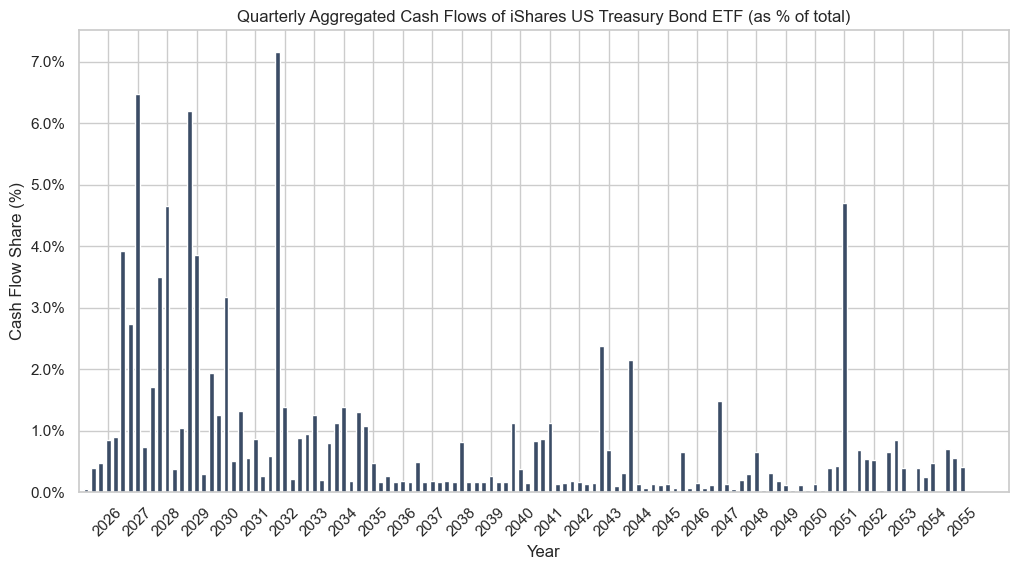

Based on the ETF holdings, approximately 45.09% in U.S. Treasury debt will mature or pay coupons within 5 years of 2025-04-23.


In [35]:
# Visualize Quarterly Aggregated Cash Flows from iShares Bond ETF Holdings as Percentages

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import QuantLib as ql

def visualize_cash_flows(file_path, eval_date="2025-04-23"):
    df_full = pd.read_csv(file_path)
    start_row = df_full[df_full.iloc[:, 0] == "Name"].index[0]
    df_bonds = df_full.iloc[start_row + 1:].copy()
    df_bonds.columns = df_full.iloc[start_row]
    df_bonds.reset_index(drop=True, inplace=True)

    def clean_number(x):
        return float(str(x).replace("’", "").replace(",", "").strip())

    df_bonds = df_bonds[df_bonds["Price"].notnull() & df_bonds["Coupon (%)"].notnull()].copy()
    df_bonds["Coupon"] = df_bonds["Coupon (%)"].astype(float) / 100
    df_bonds["Price"] = df_bonds["Price"].apply(clean_number)
    df_bonds["ParValue"] = df_bonds["Par Value"].apply(clean_number)

    def parse_maturity(date_str):
        try:
            return pd.to_datetime(date_str, format="%b. %d, %Y")
        except:
            return pd.NaT

    df_bonds["MaturityDate"] = df_bonds["Maturity"].apply(parse_maturity)
    df_bonds = df_bonds[df_bonds["MaturityDate"].notnull()]

    ql_eval_date = ql.Date().from_date(pd.to_datetime(eval_date).date())
    ql.Settings.instance().evaluationDate = ql_eval_date
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)

    raw_flows = []

    for _, row in df_bonds.iterrows():
        issue_date = ql_eval_date
        maturity_date = ql.Date(row["MaturityDate"].day, row["MaturityDate"].month, row["MaturityDate"].year)
        schedule = ql.Schedule(issue_date, maturity_date, ql.Period(ql.Semiannual),
                               calendar, ql.Unadjusted, ql.Unadjusted,
                               ql.DateGeneration.Backward, False)
        bond = ql.FixedRateBond(1, row["ParValue"], schedule,
                                [row["Coupon"]], ql.ActualActual(ql.ActualActual.Bond))
        for cf in bond.cashflows():
            if cf.date() > ql_eval_date:
                date = pd.Timestamp(cf.date().to_date())
                raw_flows.append((date, cf.amount()))

    # Convert to DataFrame
    df_cf = pd.DataFrame(raw_flows, columns=["Date", "Amount"])

    # Group by quarter
    df_cf["Quarter"] = df_cf["Date"].dt.to_period("Q").dt.to_timestamp()
    quarterly_cf = df_cf.groupby("Quarter", as_index=False)["Amount"].sum()

    # Normalize to percentages
    quarterly_cf["Amount"] = quarterly_cf["Amount"] / quarterly_cf["Amount"].sum()

    # Plot
    plt.bar(quarterly_cf["Quarter"], quarterly_cf["Amount"], width=60)
    plt.title("Quarterly Aggregated Cash Flows of iShares US Treasury Bond ETF (as % of total)")
    plt.xlabel("Year")
    plt.ylabel("Cash Flow Share (%)")
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    
    # Set x-axis ticks to annual frequency
    # Limit x-axis to start from 2025
    plt.xlim(pd.Timestamp("2025-01-01"), None)
    yearly_ticks = pd.date_range(start=quarterly_cf["Quarter"].min(), 
                                 end=quarterly_cf["Quarter"].max(), 
                                 freq='YS')  # Year Start
    plt.xticks(yearly_ticks, [d.year for d in yearly_ticks], rotation=45)

    plt.grid(True)
    plt.show()

    return quarterly_cf

# Run it
cf_df = visualize_cash_flows(f'{PATH_TO_CSV_FILES}iShares-US-Treasury-Bond-ETF_fund_20250423.csv', eval_date="2025-04-23")

from datetime import datetime, timedelta
# Define evaluation date
eval_date = pd.to_datetime("2025-04-23")
cutoff_date = eval_date + pd.DateOffset(years=5)
# Filter cash flows due within 1 year
cf_within_period = cf_df[cf_df["Quarter"] <= cutoff_date]
total_period_refinance = cf_within_period["Amount"].sum() * 100
# Format as f-string
print(f"Based on the ETF holdings, approximately {total_period_refinance :,.2f}% in U.S. Treasury debt will mature or pay coupons within 5 years of {eval_date.date()}.")

In [36]:
short_term = par_yield_df.loc[par_yield_df["Tenor"] == 1, "Par Yield (%)"].values[0] / 100
medium_term = par_yield_df.loc[par_yield_df["Tenor"] == 3, "Par Yield (%)"].values[0] / 100
long_term = par_yield_df.loc[par_yield_df["Tenor"] == 10, "Par Yield (%)"].values[0] / 100

term_premium = long_term - short_term
curve_shape = "Inverted" if term_premium < 0 else "Normal/Steep"

print(f"Short-term (0.5Y) rate: {short_term:.2%}")
print(f"Long-term (10Y) rate: {long_term:.2%}")
print(f"Term Premium: {term_premium:.2%}")
print(f"Yield Curve Shape: {curve_shape}")

Short-term (0.5Y) rate: 4.15%
Long-term (10Y) rate: 4.39%
Term Premium: 0.24%
Yield Curve Shape: Normal/Steep


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7a3fb14b-f2b7-48f8-8ca9-4b8a80e85a68' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>